In [1]:
#  Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

In [4]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [5]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [6]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [7]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [8]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [9]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [10]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [11]:
#** Define the fixed sets structure to use in the parameters of the gams optimization process
#set genLimitInfo 'Indicate the number of columns of information from generators'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set loadLimitInfo 'Indicate the number of columns of information from loads'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set storLimitInfo 'Indicate the number of columns of information from storage units'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set v2gLimitInfo 'Indicate the number of columns of information from electric vehicles'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set csLimitInfo 'Indicate the number of columns of information from charging stations'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

#genLimitInfo = np.arange(1, genLimit.shape[2]+1)
#loadLimitInfo = np.arange(1, loadLimit.shape[2]+1)
#storLimitInfo = np.arange(1, storLimit.shape[2]+1)
#v2gLimitInfo = np.arange(1, v2gLimit.shape[2]+1)
#csLimitInfo = np.arange(1, csLimit.shape[0]+1)

In [12]:
# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(1, period+1)
_gen = np.arange(1, gen+1)
_Load = np.arange(1, Load+1)
_stor = np.arange(1, stor+1)
_v2g = np.arange(1, v2g+1)
_cs = np.arange(1, cs+1)

In [13]:
# Aux function to convert numpy into dictionaries

def _auxDictionary(a):
    temp_dictionary = {}
    
    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
                
    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]
                
    return temp_dictionary

#temp_dict1 = _auxDictionary(loadLimit)

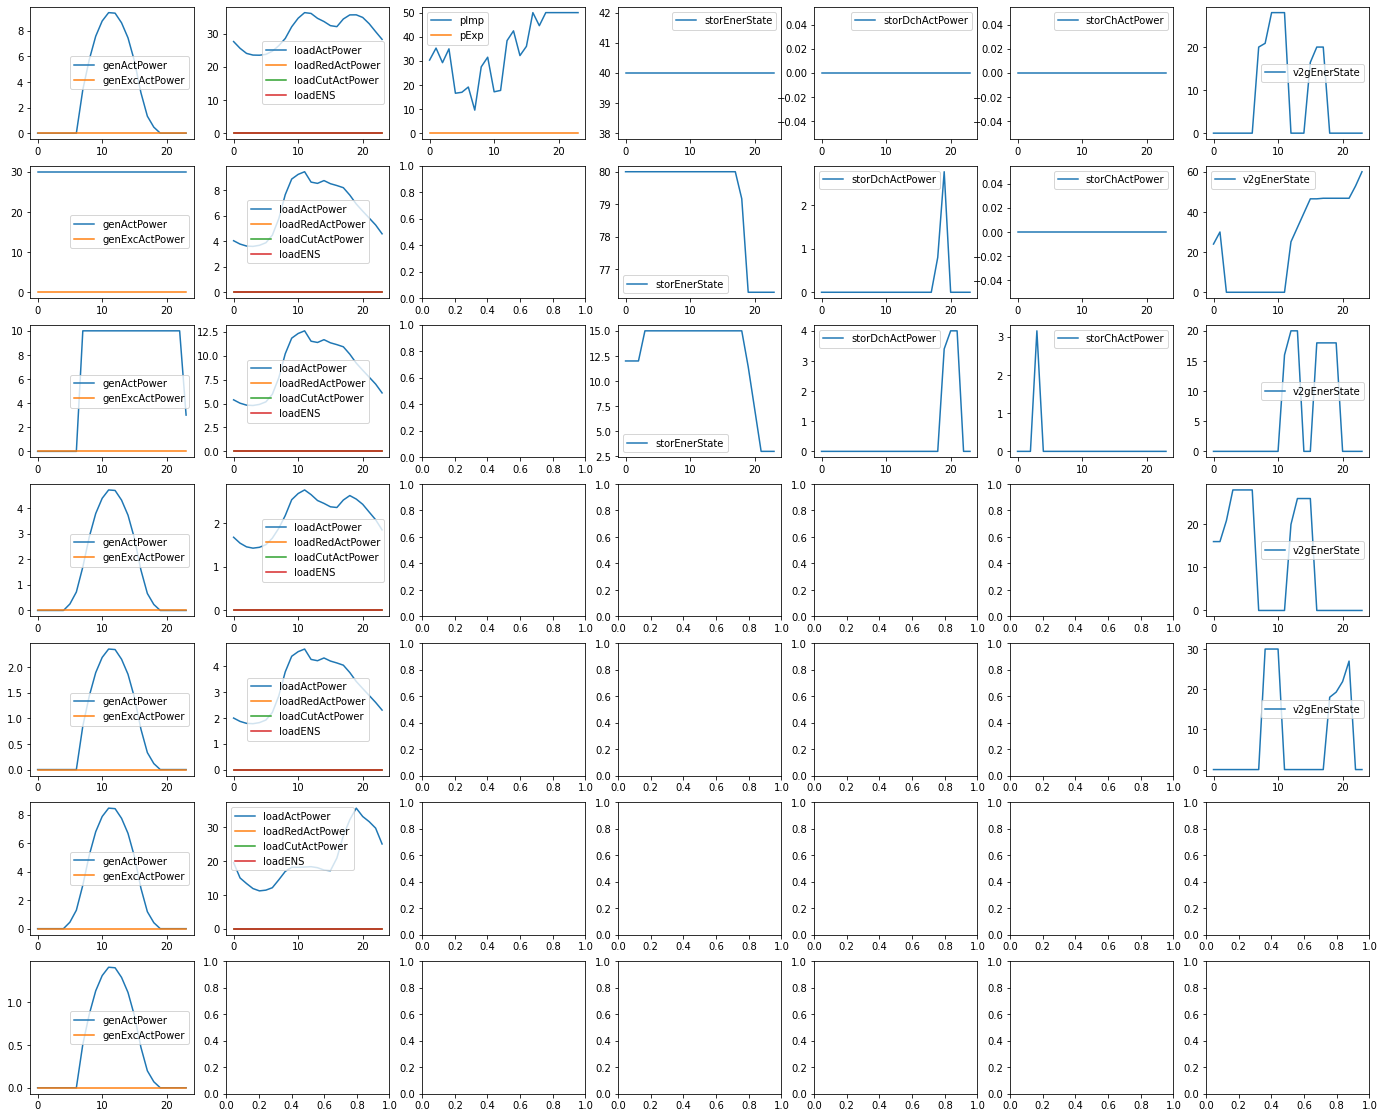

In [34]:
# Plot results

fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(24, 20))

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(result_genActPower.values[i])
    axs[i, 0].plot(result_genExcActPower.values[i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(6):
    # Loads
    axs[i, 1].plot(loadLimit[:, :, 0][i, :])
    axs[i, 1].plot(result_loadRedActPower.values[i])
    axs[i, 1].plot(result_loadCutActPower.values[i])
    axs[i, 1].plot(result_loadENS.values[i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(result_pimp.values)
axs[0, 2].plot(result_pexp.values)
axs[0, 2].legend(['pImp', 'pExp'])


for i in range(3):
    axs[i, 3].plot(result_storEnerState.values[i])
    axs[i, 3].legend(['storEnerState'])
    
for i in range(3):
    axs[i, 4].plot(result_storDchActPower.values[i])
    axs[i, 4].legend(['storDchActPower'])
    
for i in range(3):
    axs[i, 5].plot(result_storChActPower.values[i])
    axs[i, 5].legend(['storChActPower'])

for i in range(5):
    axs[i, 6].plot(result_v2gEnerState.values[i])
    axs[i, 6].legend(['v2gEnerState'])


plt.show()

In [14]:
# Pymoo import

import pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.optimize import minimize
from pymoo.termination import get_termination

In [15]:
# Class to speed up code execution

class HeuristicData(object):
    def __init__(self):
        return
    
    
    def objectiveFunction(self):
        return
    
    
    def doIteration(self):
        return
    
    
    def newIteration(self):
        return
    

class EnergyCommunity(HeuristicData):
    
    def __init__(self, parameters, variables):
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        return
    
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def newIteration(self, encoded_vals):
        self.variableAssign(self.decode(encoded_vals))
        self.doIteration()
        return

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
    
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3] * self.loadXo
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded
    

In [16]:
# Turn and recover vector for encoding

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [17]:
# Positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

# Storage variables
storDchActPower = np.ones(shape=(len(_stor), len(_t)))
storChActPower = np.ones(shape=(len(_stor), len(_t)))
storEminRelaxStor = np.ones(shape=(len(_stor), len(_t)))
storEnerState = np.ones(shape=(len(_stor), len(_t)))

# V2G variables
v2gDchActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gChActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gEnerState = np.ones(shape=(len(_v2g), len(_t)))
v2gEminRelaxEv = np.ones(shape=(len(_v2g), len(_t)))

# Charging Stations
csActPower = np.ones(shape=(len(_cs), len(_t)))
csActPowerNet = np.ones(shape=(len(_cs), len(_t)))

# Storage deg
storSegSoC = np.ones(shape=(len(_stor), len(_t), 3))
v2gSegSoC = np.ones(shape=(len(_v2g), len(_t), 3))

In [18]:
# Binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

storChXo = np.zeros(shape=(len(_stor), len(_t)))
storDchXo = np.zeros(shape=(len(_stor), len(_t)))

v2gChXo = np.zeros(shape=(len(_v2g), len(_t)))
v2gDchXo = np.zeros(shape=(len(_v2g), len(_t)))

# Battery deg binary variables
storSegXo = np.zeros(shape=(len(_stor), len(_t), 3))
v2gSegXo = np.zeros(shape=(len(_v2g), len(_t), 3))

In [19]:
# Define dictionaries

dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'EminRelaxStor': storEminRelaxStor,
            #'v2gDchActPower': v2gDchActPower,
            #'v2gChActPower': v2gChActPower,
            'genXo': genXo,
            'loadXo': loadXo,
            'storDchXo': storDchXo,
            'storChXo': storChXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}#,
            #'storSegSoC': storSegSoC,
            #'v2gSegSoC': v2gSegSoC,
            #'storSegXo': storSegXo,
            #'v2gSegXo': v2gSegXo}
encoded_vars = encode(dict_var)
encoded_vars = encoded_vars.astype(float)
decoded_vars = decode(encoded_vars, dict_var)

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'pImpMax': pMaxImp,
            'pExpMax': pMaxExp,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'storLimit': storLimit,
            'storInfo': storInfo[:, :12],
            'v2gLimit': v2gLimit,
            'v2gInfo': v2gInfo,
            'csLimit': csLimit,
            'csInfo': csInfo,
            'EV_CS_Info': EV_CS_Info,
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load,
            'stor': _stor,
            'v2g': _v2g,
            'cs': _cs,
            #'storPieceSegments': np.array([1, 2, 3]),
            'storCapCost': storInfo[:, 5] * 0.00105,
            #'storCyclesMult': np.array([1000, 1200, 700]),
            'v2gCapCost': v2gInfo[:, 4] * 0.00105}
            #'v2gCyclesMult': np.array([1000, 1000, 1000, 1000, 1000])}
encoded_pars = encode(dict_par)
encoded_pars = encoded_pars.astype(float)
decoded_pars = decode(encoded_pars, dict_par)

In [20]:
# Encoded and decoded dictionaries

encoded_dict = encode(dict_var)

decoded_dict = decode(encoded_dict, dict_var)

In [21]:
# Define min and max values allowed

minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
           'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.zeros((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}
encoded_minvals = encode(minVals)
encoded_minvals = encoded_minvals.astype(float)

maxVals = {'genActPower': 30*np.array(np.ones((1, genActPower.ravel().shape[0]))),
           'genExcActPower': 30*np.array(np.ones((1, genExcActPower.ravel().shape[0]))),
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           'loadRedActPower': loadLimit[:, :, 2].ravel(),
           'loadENS': 200*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'storDchActPower': storLimit[:, :, 1].ravel(),
           'storChActPower': storLimit[:, :, 0].ravel(),
           'EminRelaxStor': 100*np.array(np.ones((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': 200*np.array(np.ones((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': 200*np.array(np.ones((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.ones((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.ones((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.ones((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': 100*np.array(np.ones((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': 100*np.array(np.ones((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.ones((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.ones((1, v2gSegXo.ravel().shape[0])))}
encoded_maxvals = encode(maxVals)
encoded_maxvals = encoded_maxvals.astype(float)

In [22]:
# Define initial solution

sol = {'genActPower': genLimit[:, :, 0].ravel(),
       'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
       'pImp': pMaxImp.ravel(),
       'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
       'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
       'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
       'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
       'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
       'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
       #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
       #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
       'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
       'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
       'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
       'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
       'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
       'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
       #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
       #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
       #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
       #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}

encoded_sol = encode(sol)
encoded_sol = encoded_sol.astype(float)

In [23]:
# Properly shaped initial Solution

sol_shaped = {'genActPower': genLimit[:, :, 0],
              'genExcActPower': np.zeros(genExcActPower.shape),
              'pImp': pMaxImp,
              'pExp': np.zeros(pExp.shape),
              'loadRedActPower': np.zeros(loadRedActPower.shape),
              'loadENS': np.zeros(loadENS.shape),
              'storDchActPower': np.zeros(storDchActPower.shape),
              'storChActPower': np.zeros(storChActPower.shape),
              'EminRelaxStor': np.zeros(storEminRelaxStor.shape),
              #'v2gDchActPower': np.zeros(v2gDchActPower.shape),
              #'v2gChActPower': np.zeros(v2gChActPower.shape),
              'genXo': np.zeros(genXo.shape),
              'loadXo': np.zeros(loadXo.shape),
              'storDchXo': np.ones(storDchXo.shape),
              'storChXo': np.zeros(storChXo.shape),
              'v2gDchXo': np.zeros(v2gDchXo.shape),
              'v2gChXo': np.zeros(v2gChXo.shape)}

encoded_shaped = encode(sol_shaped)
decoded_shaped = decode(encoded_shaped, dict_var)

In [24]:
# Define a custom problem

class ProblemEC(Problem):
    
    def __init__(self, parameters, variables, xl, xu, n_var):
        super().__init__(n_var=n_var, n_obj=1, n_ieq_constr=0, xl=xl, xu=xu, vtype=float)
        
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        obj = []
        #print(x)
        for temp in range(x.shape[0]):
            self.variableAssign(self.decode(x[temp]))
            self.doIteration()
            obj.append(self.objFn)
        out['F'] = obj

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
    
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3] * self.loadXo
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        #print(new_variables.shape)
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded

In [25]:
# Instantiate the problem

customProblem = ProblemEC(parameters=decoded_pars,
                          variables=decoded_shaped,
                          xl=encoded_minvals,
                          xu=encoded_maxvals,
                          n_var=1584)

algorithm = PatternSearch()

termination = get_termination('n_gen', 2e4)

res = minimize(customProblem,
               algorithm,
               termination=termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 |  2.093289E+06 |  1.617039E+06
     2 |     3025 |  1.265408E+06 |  9.137768E+05
     3 |     5946 |  5.616239E+05 |  2.094711E+05
     4 |     8995 |  1.077526E+05 |  6.034050E+03
     5 |    12141 |  5.558768E+04 |  6.034050E+03
     6 |    15202 |  5.836027E+03 |  5.638003E+03
     7 |    18313 |  5.448185E+03 |  5.258367E+03
     8 |    21461 |  5.223630E+03 |  5.188894E+03
     9 |    24616 |  5.187766E+03 |  5.186637E+03
    10 |    27781 |  5.186090E+03 |  5.185543E+03
    11 |    30947 |  5.185534E+03 |  5.185524E+03
    12 |    34115 |  5.185517E+03 |  5.185510E+03
    13 |    37284 |  5.185510E+03 |  5.185510E+03
    14 |    40453 |  5.185510E+03 |  5.185510E+03
    15 |    43617 |  5.183367E+03 |  5.181225E+03
    16 |    46784 |  5.181227E+03 |  5.181225E+03
    17 |    49951 |  5.180159E+03 |  5.179093E+03
    18 |    53120 |  5.179093E+03 |  5.179093E+03
    19 |    56286 |  5.178559E+03 |  5.178024E+03


   162 |   509225 |  5.177809E+03 |  5.177809E+03
   163 |   512392 |  5.177809E+03 |  5.177809E+03
   164 |   515560 |  5.177809E+03 |  5.177809E+03
   165 |   518728 |  5.177809E+03 |  5.177809E+03
   166 |   521895 |  5.177809E+03 |  5.177809E+03
   167 |   525062 |  5.177809E+03 |  5.177809E+03
   168 |   528230 |  5.177809E+03 |  5.177809E+03
   169 |   531398 |  5.177809E+03 |  5.177809E+03
   170 |   534566 |  5.177809E+03 |  5.177809E+03
   171 |   537734 |  5.177809E+03 |  5.177809E+03
   172 |   540902 |  5.177809E+03 |  5.177809E+03
   173 |   544070 |  5.177809E+03 |  5.177809E+03
   174 |   547238 |  5.177809E+03 |  5.177809E+03
   175 |   550406 |  5.177809E+03 |  5.177809E+03
   176 |   553573 |  5.177809E+03 |  5.177809E+03
   177 |   556741 |  5.177809E+03 |  5.177809E+03
   178 |   559909 |  5.177809E+03 |  5.177809E+03
   179 |   563077 |  5.177809E+03 |  5.177809E+03
   180 |   566245 |  5.177809E+03 |  5.177809E+03
   181 |   569413 |  5.177809E+03 |  5.177809E+03


   326 |  1028735 |  5.177805E+03 |  5.177805E+03
   327 |  1031904 |  5.177805E+03 |  5.177805E+03
   328 |  1035073 |  5.177805E+03 |  5.177805E+03
   329 |  1038242 |  5.177805E+03 |  5.177805E+03
   330 |  1041411 |  5.177805E+03 |  5.177805E+03
   331 |  1044580 |  5.177805E+03 |  5.177805E+03
   332 |  1047749 |  5.177805E+03 |  5.177805E+03
   333 |  1050918 |  5.177805E+03 |  5.177805E+03
   334 |  1054087 |  5.177805E+03 |  5.177805E+03
   335 |  1057256 |  5.177805E+03 |  5.177805E+03
   336 |  1060425 |  5.177805E+03 |  5.177805E+03
   337 |  1063594 |  5.177805E+03 |  5.177805E+03
   338 |  1066763 |  5.177805E+03 |  5.177805E+03
   339 |  1069932 |  5.177805E+03 |  5.177805E+03
   340 |  1073101 |  5.177805E+03 |  5.177805E+03
   341 |  1076270 |  5.177805E+03 |  5.177805E+03
   342 |  1079439 |  5.177805E+03 |  5.177805E+03
   343 |  1082608 |  5.177805E+03 |  5.177805E+03
   344 |  1085777 |  5.177805E+03 |  5.177805E+03
   345 |  1088946 |  5.177805E+03 |  5.177805E+03


   490 |  1548451 |  5.177805E+03 |  5.177805E+03
   491 |  1551620 |  5.177805E+03 |  5.177805E+03
   492 |  1554789 |  5.177805E+03 |  5.177805E+03
   493 |  1557958 |  5.177805E+03 |  5.177805E+03
   494 |  1561127 |  5.177805E+03 |  5.177805E+03
   495 |  1564296 |  5.177805E+03 |  5.177805E+03
   496 |  1567465 |  5.177805E+03 |  5.177805E+03
   497 |  1570634 |  5.177805E+03 |  5.177805E+03
   498 |  1573803 |  5.177805E+03 |  5.177805E+03
   499 |  1576972 |  5.177805E+03 |  5.177805E+03
   500 |  1580141 |  5.177805E+03 |  5.177805E+03
   501 |  1583310 |  5.177805E+03 |  5.177805E+03
   502 |  1586479 |  5.177805E+03 |  5.177805E+03
   503 |  1589648 |  5.177805E+03 |  5.177805E+03
   504 |  1592817 |  5.177805E+03 |  5.177805E+03
   505 |  1595986 |  5.177805E+03 |  5.177805E+03
   506 |  1599155 |  5.177805E+03 |  5.177805E+03
   507 |  1602324 |  5.177805E+03 |  5.177805E+03
   508 |  1605493 |  5.177805E+03 |  5.177805E+03
   509 |  1608662 |  5.177805E+03 |  5.177805E+03


   654 |  2068167 |  5.177805E+03 |  5.177805E+03
   655 |  2071336 |  5.177805E+03 |  5.177805E+03
   656 |  2074505 |  5.177805E+03 |  5.177805E+03
   657 |  2077674 |  5.177805E+03 |  5.177805E+03
   658 |  2080843 |  5.177805E+03 |  5.177805E+03
   659 |  2084012 |  5.177805E+03 |  5.177805E+03
   660 |  2087181 |  5.177805E+03 |  5.177805E+03
   661 |  2090350 |  5.177805E+03 |  5.177805E+03
   662 |  2093519 |  5.177805E+03 |  5.177805E+03
   663 |  2096688 |  5.177805E+03 |  5.177805E+03
   664 |  2099857 |  5.177805E+03 |  5.177805E+03
   665 |  2103026 |  5.177805E+03 |  5.177805E+03
   666 |  2106195 |  5.177805E+03 |  5.177805E+03
   667 |  2109364 |  5.177805E+03 |  5.177805E+03
   668 |  2112533 |  5.177805E+03 |  5.177805E+03
   669 |  2115702 |  5.177805E+03 |  5.177805E+03
   670 |  2118871 |  5.177805E+03 |  5.177805E+03
   671 |  2122040 |  5.177805E+03 |  5.177805E+03
   672 |  2125209 |  5.177805E+03 |  5.177805E+03
   673 |  2128378 |  5.177805E+03 |  5.177805E+03


   818 |  2587883 |  5.177805E+03 |  5.177805E+03
   819 |  2591052 |  5.177805E+03 |  5.177805E+03
   820 |  2594221 |  5.177805E+03 |  5.177805E+03
   821 |  2597390 |  5.177805E+03 |  5.177805E+03
   822 |  2600559 |  5.177805E+03 |  5.177805E+03
   823 |  2603728 |  5.177805E+03 |  5.177805E+03
   824 |  2606897 |  5.177805E+03 |  5.177805E+03
   825 |  2610066 |  5.177805E+03 |  5.177805E+03
   826 |  2613235 |  5.177805E+03 |  5.177805E+03
   827 |  2616404 |  5.177805E+03 |  5.177805E+03
   828 |  2619573 |  5.177805E+03 |  5.177805E+03
   829 |  2622742 |  5.177805E+03 |  5.177805E+03
   830 |  2625911 |  5.177805E+03 |  5.177805E+03
   831 |  2629080 |  5.177805E+03 |  5.177805E+03
   832 |  2632249 |  5.177805E+03 |  5.177805E+03
   833 |  2635418 |  5.177805E+03 |  5.177805E+03
   834 |  2638587 |  5.177805E+03 |  5.177805E+03
   835 |  2641756 |  5.177805E+03 |  5.177805E+03
   836 |  2644925 |  5.177805E+03 |  5.177805E+03
   837 |  2648094 |  5.177805E+03 |  5.177805E+03


   982 |  3107599 |  5.177805E+03 |  5.177805E+03
   983 |  3110768 |  5.177805E+03 |  5.177805E+03
   984 |  3113937 |  5.177805E+03 |  5.177805E+03
   985 |  3117106 |  5.177805E+03 |  5.177805E+03
   986 |  3120275 |  5.177805E+03 |  5.177805E+03
   987 |  3123444 |  5.177805E+03 |  5.177805E+03
   988 |  3126613 |  5.177805E+03 |  5.177805E+03
   989 |  3129782 |  5.177805E+03 |  5.177805E+03
   990 |  3132951 |  5.177805E+03 |  5.177805E+03
   991 |  3136120 |  5.177805E+03 |  5.177805E+03
   992 |  3139289 |  5.177805E+03 |  5.177805E+03
   993 |  3142458 |  5.177805E+03 |  5.177805E+03
   994 |  3145627 |  5.177805E+03 |  5.177805E+03
   995 |  3148796 |  5.177805E+03 |  5.177805E+03
   996 |  3151965 |  5.177805E+03 |  5.177805E+03
   997 |  3155134 |  5.177805E+03 |  5.177805E+03
   998 |  3158303 |  5.177805E+03 |  5.177805E+03
   999 |  3161472 |  5.177805E+03 |  5.177805E+03
  1000 |  3164641 |  5.177805E+03 |  5.177805E+03
  1001 |  3167810 |  5.177805E+03 |  5.177805E+03


  1146 |  3627315 |  5.177805E+03 |  5.177805E+03
  1147 |  3630484 |  5.177805E+03 |  5.177805E+03
  1148 |  3633653 |  5.177805E+03 |  5.177805E+03
  1149 |  3636822 |  5.177805E+03 |  5.177805E+03
  1150 |  3639991 |  5.177805E+03 |  5.177805E+03
  1151 |  3643160 |  5.177805E+03 |  5.177805E+03
  1152 |  3646329 |  5.177805E+03 |  5.177805E+03
  1153 |  3649498 |  5.177805E+03 |  5.177805E+03
  1154 |  3652667 |  5.177805E+03 |  5.177805E+03
  1155 |  3655836 |  5.177805E+03 |  5.177805E+03
  1156 |  3659005 |  5.177805E+03 |  5.177805E+03
  1157 |  3662174 |  5.177805E+03 |  5.177805E+03
  1158 |  3665343 |  5.177805E+03 |  5.177805E+03
  1159 |  3668512 |  5.177805E+03 |  5.177805E+03
  1160 |  3671681 |  5.177805E+03 |  5.177805E+03
  1161 |  3674850 |  5.177805E+03 |  5.177805E+03
  1162 |  3678019 |  5.177805E+03 |  5.177805E+03
  1163 |  3681188 |  5.177805E+03 |  5.177805E+03
  1164 |  3684357 |  5.177805E+03 |  5.177805E+03
  1165 |  3687526 |  5.177805E+03 |  5.177805E+03


  1310 |  4147031 |  5.177805E+03 |  5.177805E+03
  1311 |  4150200 |  5.177805E+03 |  5.177805E+03
  1312 |  4153369 |  5.177805E+03 |  5.177805E+03
  1313 |  4156538 |  5.177805E+03 |  5.177805E+03
  1314 |  4159707 |  5.177805E+03 |  5.177805E+03
  1315 |  4162876 |  5.177805E+03 |  5.177805E+03
  1316 |  4166045 |  5.177805E+03 |  5.177805E+03
  1317 |  4169214 |  5.177805E+03 |  5.177805E+03
  1318 |  4172383 |  5.177805E+03 |  5.177805E+03
  1319 |  4175552 |  5.177805E+03 |  5.177805E+03
  1320 |  4178721 |  5.177805E+03 |  5.177805E+03
  1321 |  4181890 |  5.177805E+03 |  5.177805E+03
  1322 |  4185059 |  5.177805E+03 |  5.177805E+03
  1323 |  4188228 |  5.177805E+03 |  5.177805E+03
  1324 |  4191397 |  5.177805E+03 |  5.177805E+03
  1325 |  4194566 |  5.177805E+03 |  5.177805E+03
  1326 |  4197735 |  5.177805E+03 |  5.177805E+03
  1327 |  4200904 |  5.177805E+03 |  5.177805E+03
  1328 |  4204073 |  5.177805E+03 |  5.177805E+03
  1329 |  4207242 |  5.177805E+03 |  5.177805E+03


  1474 |  4666747 |  5.177805E+03 |  5.177805E+03
  1475 |  4669916 |  5.177805E+03 |  5.177805E+03
  1476 |  4673085 |  5.177805E+03 |  5.177805E+03
  1477 |  4676254 |  5.177805E+03 |  5.177805E+03
  1478 |  4679423 |  5.177805E+03 |  5.177805E+03
  1479 |  4682592 |  5.177805E+03 |  5.177805E+03
  1480 |  4685761 |  5.177805E+03 |  5.177805E+03
  1481 |  4688930 |  5.177805E+03 |  5.177805E+03
  1482 |  4692099 |  5.177805E+03 |  5.177805E+03
  1483 |  4695268 |  5.177805E+03 |  5.177805E+03
  1484 |  4698437 |  5.177805E+03 |  5.177805E+03
  1485 |  4701606 |  5.177805E+03 |  5.177805E+03
  1486 |  4704775 |  5.177805E+03 |  5.177805E+03
  1487 |  4707944 |  5.177805E+03 |  5.177805E+03
  1488 |  4711113 |  5.177805E+03 |  5.177805E+03
  1489 |  4714282 |  5.177805E+03 |  5.177805E+03
  1490 |  4717451 |  5.177805E+03 |  5.177805E+03
  1491 |  4720620 |  5.177805E+03 |  5.177805E+03
  1492 |  4723789 |  5.177805E+03 |  5.177805E+03
  1493 |  4726958 |  5.177805E+03 |  5.177805E+03


  1638 |  5186463 |  5.177805E+03 |  5.177805E+03
  1639 |  5189632 |  5.177805E+03 |  5.177805E+03
  1640 |  5192801 |  5.177805E+03 |  5.177805E+03
  1641 |  5195970 |  5.177805E+03 |  5.177805E+03
  1642 |  5199139 |  5.177805E+03 |  5.177805E+03
  1643 |  5202308 |  5.177805E+03 |  5.177805E+03
  1644 |  5205477 |  5.177805E+03 |  5.177805E+03
  1645 |  5208646 |  5.177805E+03 |  5.177805E+03
  1646 |  5211815 |  5.177805E+03 |  5.177805E+03
  1647 |  5214984 |  5.177805E+03 |  5.177805E+03
  1648 |  5218153 |  5.177805E+03 |  5.177805E+03
  1649 |  5221322 |  5.177805E+03 |  5.177805E+03
  1650 |  5224491 |  5.177805E+03 |  5.177805E+03
  1651 |  5227660 |  5.177805E+03 |  5.177805E+03
  1652 |  5230829 |  5.177805E+03 |  5.177805E+03
  1653 |  5233998 |  5.177805E+03 |  5.177805E+03
  1654 |  5237167 |  5.177805E+03 |  5.177805E+03
  1655 |  5240336 |  5.177805E+03 |  5.177805E+03
  1656 |  5243505 |  5.177805E+03 |  5.177805E+03
  1657 |  5246674 |  5.177805E+03 |  5.177805E+03


  1802 |  5706179 |  5.177805E+03 |  5.177805E+03
  1803 |  5709348 |  5.177805E+03 |  5.177805E+03
  1804 |  5712517 |  5.177805E+03 |  5.177805E+03
  1805 |  5715686 |  5.177805E+03 |  5.177805E+03
  1806 |  5718855 |  5.177805E+03 |  5.177805E+03
  1807 |  5722024 |  5.177805E+03 |  5.177805E+03
  1808 |  5725193 |  5.177805E+03 |  5.177805E+03
  1809 |  5728362 |  5.177805E+03 |  5.177805E+03
  1810 |  5731531 |  5.177805E+03 |  5.177805E+03
  1811 |  5734700 |  5.177805E+03 |  5.177805E+03
  1812 |  5737869 |  5.177805E+03 |  5.177805E+03
  1813 |  5741038 |  5.177805E+03 |  5.177805E+03
  1814 |  5744207 |  5.177805E+03 |  5.177805E+03
  1815 |  5747376 |  5.177805E+03 |  5.177805E+03
  1816 |  5750545 |  5.177805E+03 |  5.177805E+03
  1817 |  5753714 |  5.177805E+03 |  5.177805E+03
  1818 |  5756883 |  5.177805E+03 |  5.177805E+03
  1819 |  5760052 |  5.177805E+03 |  5.177805E+03
  1820 |  5763221 |  5.177805E+03 |  5.177805E+03
  1821 |  5766390 |  5.177805E+03 |  5.177805E+03


  1966 |  6225895 |  5.177805E+03 |  5.177805E+03
  1967 |  6229064 |  5.177805E+03 |  5.177805E+03
  1968 |  6232233 |  5.177805E+03 |  5.177805E+03
  1969 |  6235402 |  5.177805E+03 |  5.177805E+03
  1970 |  6238571 |  5.177805E+03 |  5.177805E+03
  1971 |  6241740 |  5.177805E+03 |  5.177805E+03
  1972 |  6244909 |  5.177805E+03 |  5.177805E+03
  1973 |  6248078 |  5.177805E+03 |  5.177805E+03
  1974 |  6251247 |  5.177805E+03 |  5.177805E+03
  1975 |  6254416 |  5.177805E+03 |  5.177805E+03
  1976 |  6257585 |  5.177805E+03 |  5.177805E+03
  1977 |  6260754 |  5.177805E+03 |  5.177805E+03
  1978 |  6263923 |  5.177805E+03 |  5.177805E+03
  1979 |  6267092 |  5.177805E+03 |  5.177805E+03
  1980 |  6270261 |  5.177805E+03 |  5.177805E+03
  1981 |  6273430 |  5.177805E+03 |  5.177805E+03
  1982 |  6276599 |  5.177805E+03 |  5.177805E+03
  1983 |  6279768 |  5.177805E+03 |  5.177805E+03
  1984 |  6282937 |  5.177805E+03 |  5.177805E+03
  1985 |  6286106 |  5.177805E+03 |  5.177805E+03


  2130 |  6745611 |  5.177805E+03 |  5.177805E+03
  2131 |  6748780 |  5.177805E+03 |  5.177805E+03
  2132 |  6751949 |  5.177805E+03 |  5.177805E+03
  2133 |  6755118 |  5.177805E+03 |  5.177805E+03
  2134 |  6758287 |  5.177805E+03 |  5.177805E+03
  2135 |  6761456 |  5.177805E+03 |  5.177805E+03
  2136 |  6764625 |  5.177805E+03 |  5.177805E+03
  2137 |  6767794 |  5.177805E+03 |  5.177805E+03
  2138 |  6770963 |  5.177805E+03 |  5.177805E+03
  2139 |  6774132 |  5.177805E+03 |  5.177805E+03
  2140 |  6777301 |  5.177805E+03 |  5.177805E+03
  2141 |  6780470 |  5.177805E+03 |  5.177805E+03
  2142 |  6783639 |  5.177805E+03 |  5.177805E+03
  2143 |  6786808 |  5.177805E+03 |  5.177805E+03
  2144 |  6789977 |  5.177805E+03 |  5.177805E+03
  2145 |  6793146 |  5.177805E+03 |  5.177805E+03
  2146 |  6796315 |  5.177805E+03 |  5.177805E+03
  2147 |  6799484 |  5.177805E+03 |  5.177805E+03
  2148 |  6802653 |  5.177805E+03 |  5.177805E+03
  2149 |  6805822 |  5.177805E+03 |  5.177805E+03


  2294 |  7265327 |  5.177805E+03 |  5.177805E+03
  2295 |  7268496 |  5.177805E+03 |  5.177805E+03
  2296 |  7271665 |  5.177805E+03 |  5.177805E+03
  2297 |  7274834 |  5.177805E+03 |  5.177805E+03
  2298 |  7278003 |  5.177805E+03 |  5.177805E+03
  2299 |  7281172 |  5.177805E+03 |  5.177805E+03
  2300 |  7284341 |  5.177805E+03 |  5.177805E+03
  2301 |  7287510 |  5.177805E+03 |  5.177805E+03
  2302 |  7290679 |  5.177805E+03 |  5.177805E+03
  2303 |  7293848 |  5.177805E+03 |  5.177805E+03
  2304 |  7297017 |  5.177805E+03 |  5.177805E+03
  2305 |  7300186 |  5.177805E+03 |  5.177805E+03
  2306 |  7303355 |  5.177805E+03 |  5.177805E+03
  2307 |  7306524 |  5.177805E+03 |  5.177805E+03
  2308 |  7309693 |  5.177805E+03 |  5.177805E+03
  2309 |  7312862 |  5.177805E+03 |  5.177805E+03
  2310 |  7316031 |  5.177805E+03 |  5.177805E+03
  2311 |  7319200 |  5.177805E+03 |  5.177805E+03
  2312 |  7322369 |  5.177805E+03 |  5.177805E+03
  2313 |  7325538 |  5.177805E+03 |  5.177805E+03


  2458 |  7785043 |  5.177805E+03 |  5.177805E+03
  2459 |  7788212 |  5.177805E+03 |  5.177805E+03
  2460 |  7791381 |  5.177805E+03 |  5.177805E+03
  2461 |  7794550 |  5.177805E+03 |  5.177805E+03
  2462 |  7797719 |  5.177805E+03 |  5.177805E+03
  2463 |  7800888 |  5.177805E+03 |  5.177805E+03
  2464 |  7804057 |  5.177805E+03 |  5.177805E+03
  2465 |  7807226 |  5.177805E+03 |  5.177805E+03
  2466 |  7810395 |  5.177805E+03 |  5.177805E+03
  2467 |  7813564 |  5.177805E+03 |  5.177805E+03
  2468 |  7816733 |  5.177805E+03 |  5.177805E+03
  2469 |  7819902 |  5.177805E+03 |  5.177805E+03
  2470 |  7823071 |  5.177805E+03 |  5.177805E+03
  2471 |  7826240 |  5.177805E+03 |  5.177805E+03
  2472 |  7829409 |  5.177805E+03 |  5.177805E+03
  2473 |  7832578 |  5.177805E+03 |  5.177805E+03
  2474 |  7835747 |  5.177805E+03 |  5.177805E+03
  2475 |  7838916 |  5.177805E+03 |  5.177805E+03
  2476 |  7842085 |  5.177805E+03 |  5.177805E+03
  2477 |  7845254 |  5.177805E+03 |  5.177805E+03


  2622 |  8304759 |  5.177805E+03 |  5.177805E+03
  2623 |  8307928 |  5.177805E+03 |  5.177805E+03
  2624 |  8311097 |  5.177805E+03 |  5.177805E+03
  2625 |  8314266 |  5.177805E+03 |  5.177805E+03
  2626 |  8317435 |  5.177805E+03 |  5.177805E+03
  2627 |  8320604 |  5.177805E+03 |  5.177805E+03
  2628 |  8323773 |  5.177805E+03 |  5.177805E+03
  2629 |  8326942 |  5.177805E+03 |  5.177805E+03
  2630 |  8330111 |  5.177805E+03 |  5.177805E+03
  2631 |  8333280 |  5.177805E+03 |  5.177805E+03
  2632 |  8336449 |  5.177805E+03 |  5.177805E+03
  2633 |  8339618 |  5.177805E+03 |  5.177805E+03
  2634 |  8342787 |  5.177805E+03 |  5.177805E+03
  2635 |  8345956 |  5.177805E+03 |  5.177805E+03
  2636 |  8349125 |  5.177805E+03 |  5.177805E+03
  2637 |  8352294 |  5.177805E+03 |  5.177805E+03
  2638 |  8355463 |  5.177805E+03 |  5.177805E+03
  2639 |  8358632 |  5.177805E+03 |  5.177805E+03
  2640 |  8361801 |  5.177805E+03 |  5.177805E+03
  2641 |  8364970 |  5.177805E+03 |  5.177805E+03


  2786 |  8824475 |  5.177805E+03 |  5.177805E+03
  2787 |  8827644 |  5.177805E+03 |  5.177805E+03
  2788 |  8830813 |  5.177805E+03 |  5.177805E+03
  2789 |  8833982 |  5.177805E+03 |  5.177805E+03
  2790 |  8837151 |  5.177805E+03 |  5.177805E+03
  2791 |  8840320 |  5.177805E+03 |  5.177805E+03
  2792 |  8843489 |  5.177805E+03 |  5.177805E+03
  2793 |  8846658 |  5.177805E+03 |  5.177805E+03
  2794 |  8849827 |  5.177805E+03 |  5.177805E+03
  2795 |  8852996 |  5.177805E+03 |  5.177805E+03
  2796 |  8856165 |  5.177805E+03 |  5.177805E+03
  2797 |  8859334 |  5.177805E+03 |  5.177805E+03
  2798 |  8862503 |  5.177805E+03 |  5.177805E+03
  2799 |  8865672 |  5.177805E+03 |  5.177805E+03
  2800 |  8868841 |  5.177805E+03 |  5.177805E+03
  2801 |  8872010 |  5.177805E+03 |  5.177805E+03
  2802 |  8875179 |  5.177805E+03 |  5.177805E+03
  2803 |  8878348 |  5.177805E+03 |  5.177805E+03
  2804 |  8881517 |  5.177805E+03 |  5.177805E+03
  2805 |  8884686 |  5.177805E+03 |  5.177805E+03


  2950 |  9344191 |  5.177805E+03 |  5.177805E+03
  2951 |  9347360 |  5.177805E+03 |  5.177805E+03
  2952 |  9350529 |  5.177805E+03 |  5.177805E+03
  2953 |  9353698 |  5.177805E+03 |  5.177805E+03
  2954 |  9356867 |  5.177805E+03 |  5.177805E+03
  2955 |  9360036 |  5.177805E+03 |  5.177805E+03
  2956 |  9363205 |  5.177805E+03 |  5.177805E+03
  2957 |  9366374 |  5.177805E+03 |  5.177805E+03
  2958 |  9369543 |  5.177805E+03 |  5.177805E+03
  2959 |  9372712 |  5.177805E+03 |  5.177805E+03
  2960 |  9375881 |  5.177805E+03 |  5.177805E+03
  2961 |  9379050 |  5.177805E+03 |  5.177805E+03
  2962 |  9382219 |  5.177805E+03 |  5.177805E+03
  2963 |  9385388 |  5.177805E+03 |  5.177805E+03
  2964 |  9388557 |  5.177805E+03 |  5.177805E+03
  2965 |  9391726 |  5.177805E+03 |  5.177805E+03
  2966 |  9394895 |  5.177805E+03 |  5.177805E+03
  2967 |  9398064 |  5.177805E+03 |  5.177805E+03
  2968 |  9401233 |  5.177805E+03 |  5.177805E+03
  2969 |  9404402 |  5.177805E+03 |  5.177805E+03


  3114 |  9863907 |  5.177805E+03 |  5.177805E+03
  3115 |  9867076 |  5.177805E+03 |  5.177805E+03
  3116 |  9870245 |  5.177805E+03 |  5.177805E+03
  3117 |  9873414 |  5.177805E+03 |  5.177805E+03
  3118 |  9876583 |  5.177805E+03 |  5.177805E+03
  3119 |  9879752 |  5.177805E+03 |  5.177805E+03
  3120 |  9882921 |  5.177805E+03 |  5.177805E+03
  3121 |  9886090 |  5.177805E+03 |  5.177805E+03
  3122 |  9889259 |  5.177805E+03 |  5.177805E+03
  3123 |  9892428 |  5.177805E+03 |  5.177805E+03
  3124 |  9895597 |  5.177805E+03 |  5.177805E+03
  3125 |  9898766 |  5.177805E+03 |  5.177805E+03
  3126 |  9901935 |  5.177805E+03 |  5.177805E+03
  3127 |  9905104 |  5.177805E+03 |  5.177805E+03
  3128 |  9908273 |  5.177805E+03 |  5.177805E+03
  3129 |  9911442 |  5.177805E+03 |  5.177805E+03
  3130 |  9914611 |  5.177805E+03 |  5.177805E+03
  3131 |  9917780 |  5.177805E+03 |  5.177805E+03
  3132 |  9920949 |  5.177805E+03 |  5.177805E+03
  3133 |  9924118 |  5.177805E+03 |  5.177805E+03


  3278 | 10383623 |  5.177805E+03 |  5.177805E+03
  3279 | 10386792 |  5.177805E+03 |  5.177805E+03
  3280 | 10389961 |  5.177805E+03 |  5.177805E+03
  3281 | 10393130 |  5.177805E+03 |  5.177805E+03
  3282 | 10396299 |  5.177805E+03 |  5.177805E+03
  3283 | 10399468 |  5.177805E+03 |  5.177805E+03
  3284 | 10402637 |  5.177805E+03 |  5.177805E+03
  3285 | 10405806 |  5.177805E+03 |  5.177805E+03
  3286 | 10408975 |  5.177805E+03 |  5.177805E+03
  3287 | 10412144 |  5.177805E+03 |  5.177805E+03
  3288 | 10415313 |  5.177805E+03 |  5.177805E+03
  3289 | 10418482 |  5.177805E+03 |  5.177805E+03
  3290 | 10421651 |  5.177805E+03 |  5.177805E+03
  3291 | 10424820 |  5.177805E+03 |  5.177805E+03
  3292 | 10427989 |  5.177805E+03 |  5.177805E+03
  3293 | 10431158 |  5.177805E+03 |  5.177805E+03
  3294 | 10434327 |  5.177805E+03 |  5.177805E+03
  3295 | 10437496 |  5.177805E+03 |  5.177805E+03
  3296 | 10440665 |  5.177805E+03 |  5.177805E+03
  3297 | 10443834 |  5.177805E+03 |  5.177805E+03


  3442 | 10903339 |  5.177805E+03 |  5.177805E+03
  3443 | 10906508 |  5.177805E+03 |  5.177805E+03
  3444 | 10909677 |  5.177805E+03 |  5.177805E+03
  3445 | 10912846 |  5.177805E+03 |  5.177805E+03
  3446 | 10916015 |  5.177805E+03 |  5.177805E+03
  3447 | 10919184 |  5.177805E+03 |  5.177805E+03
  3448 | 10922353 |  5.177805E+03 |  5.177805E+03
  3449 | 10925522 |  5.177805E+03 |  5.177805E+03
  3450 | 10928691 |  5.177805E+03 |  5.177805E+03
  3451 | 10931860 |  5.177805E+03 |  5.177805E+03
  3452 | 10935029 |  5.177805E+03 |  5.177805E+03
  3453 | 10938198 |  5.177805E+03 |  5.177805E+03
  3454 | 10941367 |  5.177805E+03 |  5.177805E+03
  3455 | 10944536 |  5.177805E+03 |  5.177805E+03
  3456 | 10947705 |  5.177805E+03 |  5.177805E+03
  3457 | 10950874 |  5.177805E+03 |  5.177805E+03
  3458 | 10954043 |  5.177805E+03 |  5.177805E+03
  3459 | 10957212 |  5.177805E+03 |  5.177805E+03
  3460 | 10960381 |  5.177805E+03 |  5.177805E+03
  3461 | 10963550 |  5.177805E+03 |  5.177805E+03


  3606 | 11423055 |  5.177805E+03 |  5.177805E+03
  3607 | 11426224 |  5.177805E+03 |  5.177805E+03
  3608 | 11429393 |  5.177805E+03 |  5.177805E+03
  3609 | 11432562 |  5.177805E+03 |  5.177805E+03
  3610 | 11435731 |  5.177805E+03 |  5.177805E+03
  3611 | 11438900 |  5.177805E+03 |  5.177805E+03
  3612 | 11442069 |  5.177805E+03 |  5.177805E+03
  3613 | 11445238 |  5.177805E+03 |  5.177805E+03
  3614 | 11448407 |  5.177805E+03 |  5.177805E+03
  3615 | 11451576 |  5.177805E+03 |  5.177805E+03
  3616 | 11454745 |  5.177805E+03 |  5.177805E+03
  3617 | 11457914 |  5.177805E+03 |  5.177805E+03
  3618 | 11461083 |  5.177805E+03 |  5.177805E+03
  3619 | 11464252 |  5.177805E+03 |  5.177805E+03
  3620 | 11467421 |  5.177805E+03 |  5.177805E+03
  3621 | 11470590 |  5.177805E+03 |  5.177805E+03
  3622 | 11473759 |  5.177805E+03 |  5.177805E+03
  3623 | 11476928 |  5.177805E+03 |  5.177805E+03
  3624 | 11480097 |  5.177805E+03 |  5.177805E+03
  3625 | 11483266 |  5.177805E+03 |  5.177805E+03


  3770 | 11942771 |  5.177805E+03 |  5.177805E+03
  3771 | 11945940 |  5.177805E+03 |  5.177805E+03
  3772 | 11949109 |  5.177805E+03 |  5.177805E+03
  3773 | 11952278 |  5.177805E+03 |  5.177805E+03
  3774 | 11955447 |  5.177805E+03 |  5.177805E+03
  3775 | 11958616 |  5.177805E+03 |  5.177805E+03
  3776 | 11961785 |  5.177805E+03 |  5.177805E+03
  3777 | 11964954 |  5.177805E+03 |  5.177805E+03
  3778 | 11968123 |  5.177805E+03 |  5.177805E+03
  3779 | 11971292 |  5.177805E+03 |  5.177805E+03
  3780 | 11974461 |  5.177805E+03 |  5.177805E+03
  3781 | 11977630 |  5.177805E+03 |  5.177805E+03
  3782 | 11980799 |  5.177805E+03 |  5.177805E+03
  3783 | 11983968 |  5.177805E+03 |  5.177805E+03
  3784 | 11987137 |  5.177805E+03 |  5.177805E+03
  3785 | 11990306 |  5.177805E+03 |  5.177805E+03
  3786 | 11993475 |  5.177805E+03 |  5.177805E+03
  3787 | 11996644 |  5.177805E+03 |  5.177805E+03
  3788 | 11999813 |  5.177805E+03 |  5.177805E+03
  3789 | 12002982 |  5.177805E+03 |  5.177805E+03


  3934 | 12462487 |  5.177805E+03 |  5.177805E+03
  3935 | 12465656 |  5.177805E+03 |  5.177805E+03
  3936 | 12468825 |  5.177805E+03 |  5.177805E+03
  3937 | 12471994 |  5.177805E+03 |  5.177805E+03
  3938 | 12475163 |  5.177805E+03 |  5.177805E+03
  3939 | 12478332 |  5.177805E+03 |  5.177805E+03
  3940 | 12481501 |  5.177805E+03 |  5.177805E+03
  3941 | 12484670 |  5.177805E+03 |  5.177805E+03
  3942 | 12487839 |  5.177805E+03 |  5.177805E+03
  3943 | 12491008 |  5.177805E+03 |  5.177805E+03
  3944 | 12494177 |  5.177805E+03 |  5.177805E+03
  3945 | 12497346 |  5.177805E+03 |  5.177805E+03
  3946 | 12500515 |  5.177805E+03 |  5.177805E+03
  3947 | 12503684 |  5.177805E+03 |  5.177805E+03
  3948 | 12506853 |  5.177805E+03 |  5.177805E+03
  3949 | 12510022 |  5.177805E+03 |  5.177805E+03
  3950 | 12513191 |  5.177805E+03 |  5.177805E+03
  3951 | 12516360 |  5.177805E+03 |  5.177805E+03
  3952 | 12519529 |  5.177805E+03 |  5.177805E+03
  3953 | 12522698 |  5.177805E+03 |  5.177805E+03


  4098 | 12982203 |  5.177805E+03 |  5.177805E+03
  4099 | 12985372 |  5.177805E+03 |  5.177805E+03
  4100 | 12988541 |  5.177805E+03 |  5.177805E+03
  4101 | 12991710 |  5.177805E+03 |  5.177805E+03
  4102 | 12994879 |  5.177805E+03 |  5.177805E+03
  4103 | 12998048 |  5.177805E+03 |  5.177805E+03
  4104 | 13001217 |  5.177805E+03 |  5.177805E+03
  4105 | 13004386 |  5.177805E+03 |  5.177805E+03
  4106 | 13007555 |  5.177805E+03 |  5.177805E+03
  4107 | 13010724 |  5.177805E+03 |  5.177805E+03
  4108 | 13013893 |  5.177805E+03 |  5.177805E+03
  4109 | 13017062 |  5.177805E+03 |  5.177805E+03
  4110 | 13020231 |  5.177805E+03 |  5.177805E+03
  4111 | 13023400 |  5.177805E+03 |  5.177805E+03
  4112 | 13026569 |  5.177805E+03 |  5.177805E+03
  4113 | 13029738 |  5.177805E+03 |  5.177805E+03
  4114 | 13032907 |  5.177805E+03 |  5.177805E+03
  4115 | 13036076 |  5.177805E+03 |  5.177805E+03
  4116 | 13039245 |  5.177805E+03 |  5.177805E+03
  4117 | 13042414 |  5.177805E+03 |  5.177805E+03


  4262 | 13501919 |  5.177805E+03 |  5.177805E+03
  4263 | 13505088 |  5.177805E+03 |  5.177805E+03
  4264 | 13508257 |  5.177805E+03 |  5.177805E+03
  4265 | 13511426 |  5.177805E+03 |  5.177805E+03
  4266 | 13514595 |  5.177805E+03 |  5.177805E+03
  4267 | 13517764 |  5.177805E+03 |  5.177805E+03
  4268 | 13520933 |  5.177805E+03 |  5.177805E+03
  4269 | 13524102 |  5.177805E+03 |  5.177805E+03
  4270 | 13527271 |  5.177805E+03 |  5.177805E+03
  4271 | 13530440 |  5.177805E+03 |  5.177805E+03
  4272 | 13533609 |  5.177805E+03 |  5.177805E+03
  4273 | 13536778 |  5.177805E+03 |  5.177805E+03
  4274 | 13539947 |  5.177805E+03 |  5.177805E+03
  4275 | 13543116 |  5.177805E+03 |  5.177805E+03
  4276 | 13546285 |  5.177805E+03 |  5.177805E+03
  4277 | 13549454 |  5.177805E+03 |  5.177805E+03
  4278 | 13552623 |  5.177805E+03 |  5.177805E+03
  4279 | 13555792 |  5.177805E+03 |  5.177805E+03
  4280 | 13558961 |  5.177805E+03 |  5.177805E+03
  4281 | 13562130 |  5.177805E+03 |  5.177805E+03


  4426 | 14021635 |  5.177805E+03 |  5.177805E+03
  4427 | 14024804 |  5.177805E+03 |  5.177805E+03
  4428 | 14027973 |  5.177805E+03 |  5.177805E+03
  4429 | 14031142 |  5.177805E+03 |  5.177805E+03
  4430 | 14034311 |  5.177805E+03 |  5.177805E+03
  4431 | 14037480 |  5.177805E+03 |  5.177805E+03
  4432 | 14040649 |  5.177805E+03 |  5.177805E+03
  4433 | 14043818 |  5.177805E+03 |  5.177805E+03
  4434 | 14046987 |  5.177805E+03 |  5.177805E+03
  4435 | 14050156 |  5.177805E+03 |  5.177805E+03
  4436 | 14053325 |  5.177805E+03 |  5.177805E+03
  4437 | 14056494 |  5.177805E+03 |  5.177805E+03
  4438 | 14059663 |  5.177805E+03 |  5.177805E+03
  4439 | 14062832 |  5.177805E+03 |  5.177805E+03
  4440 | 14066001 |  5.177805E+03 |  5.177805E+03
  4441 | 14069170 |  5.177805E+03 |  5.177805E+03
  4442 | 14072339 |  5.177805E+03 |  5.177805E+03
  4443 | 14075508 |  5.177805E+03 |  5.177805E+03
  4444 | 14078677 |  5.177805E+03 |  5.177805E+03
  4445 | 14081846 |  5.177805E+03 |  5.177805E+03


  4590 | 14541351 |  5.177805E+03 |  5.177805E+03
  4591 | 14544520 |  5.177805E+03 |  5.177805E+03
  4592 | 14547689 |  5.177805E+03 |  5.177805E+03
  4593 | 14550858 |  5.177805E+03 |  5.177805E+03
  4594 | 14554027 |  5.177805E+03 |  5.177805E+03
  4595 | 14557196 |  5.177805E+03 |  5.177805E+03
  4596 | 14560365 |  5.177805E+03 |  5.177805E+03
  4597 | 14563534 |  5.177805E+03 |  5.177805E+03
  4598 | 14566703 |  5.177805E+03 |  5.177805E+03
  4599 | 14569872 |  5.177805E+03 |  5.177805E+03
  4600 | 14573041 |  5.177805E+03 |  5.177805E+03
  4601 | 14576210 |  5.177805E+03 |  5.177805E+03
  4602 | 14579379 |  5.177805E+03 |  5.177805E+03
  4603 | 14582548 |  5.177805E+03 |  5.177805E+03
  4604 | 14585717 |  5.177805E+03 |  5.177805E+03
  4605 | 14588886 |  5.177805E+03 |  5.177805E+03
  4606 | 14592055 |  5.177805E+03 |  5.177805E+03
  4607 | 14595224 |  5.177805E+03 |  5.177805E+03
  4608 | 14598393 |  5.177805E+03 |  5.177805E+03
  4609 | 14601562 |  5.177805E+03 |  5.177805E+03


  4754 | 15061067 |  5.177805E+03 |  5.177805E+03
  4755 | 15064236 |  5.177805E+03 |  5.177805E+03
  4756 | 15067405 |  5.177805E+03 |  5.177805E+03
  4757 | 15070574 |  5.177805E+03 |  5.177805E+03
  4758 | 15073743 |  5.177805E+03 |  5.177805E+03
  4759 | 15076912 |  5.177805E+03 |  5.177805E+03
  4760 | 15080081 |  5.177805E+03 |  5.177805E+03
  4761 | 15083250 |  5.177805E+03 |  5.177805E+03
  4762 | 15086419 |  5.177805E+03 |  5.177805E+03
  4763 | 15089588 |  5.177805E+03 |  5.177805E+03
  4764 | 15092757 |  5.177805E+03 |  5.177805E+03
  4765 | 15095926 |  5.177805E+03 |  5.177805E+03
  4766 | 15099095 |  5.177805E+03 |  5.177805E+03
  4767 | 15102264 |  5.177805E+03 |  5.177805E+03
  4768 | 15105433 |  5.177805E+03 |  5.177805E+03
  4769 | 15108602 |  5.177805E+03 |  5.177805E+03
  4770 | 15111771 |  5.177805E+03 |  5.177805E+03
  4771 | 15114940 |  5.177805E+03 |  5.177805E+03
  4772 | 15118109 |  5.177805E+03 |  5.177805E+03
  4773 | 15121278 |  5.177805E+03 |  5.177805E+03


  4918 | 15580783 |  5.177805E+03 |  5.177805E+03
  4919 | 15583952 |  5.177805E+03 |  5.177805E+03
  4920 | 15587121 |  5.177805E+03 |  5.177805E+03
  4921 | 15590290 |  5.177805E+03 |  5.177805E+03
  4922 | 15593459 |  5.177805E+03 |  5.177805E+03
  4923 | 15596628 |  5.177805E+03 |  5.177805E+03
  4924 | 15599797 |  5.177805E+03 |  5.177805E+03
  4925 | 15602966 |  5.177805E+03 |  5.177805E+03
  4926 | 15606135 |  5.177805E+03 |  5.177805E+03
  4927 | 15609304 |  5.177805E+03 |  5.177805E+03
  4928 | 15612473 |  5.177805E+03 |  5.177805E+03
  4929 | 15615642 |  5.177805E+03 |  5.177805E+03
  4930 | 15618811 |  5.177805E+03 |  5.177805E+03
  4931 | 15621980 |  5.177805E+03 |  5.177805E+03
  4932 | 15625149 |  5.177805E+03 |  5.177805E+03
  4933 | 15628318 |  5.177805E+03 |  5.177805E+03
  4934 | 15631487 |  5.177805E+03 |  5.177805E+03
  4935 | 15634656 |  5.177805E+03 |  5.177805E+03
  4936 | 15637825 |  5.177805E+03 |  5.177805E+03
  4937 | 15640994 |  5.177805E+03 |  5.177805E+03


  5082 | 16100499 |  5.177805E+03 |  5.177805E+03
  5083 | 16103668 |  5.177805E+03 |  5.177805E+03
  5084 | 16106837 |  5.177805E+03 |  5.177805E+03
  5085 | 16110006 |  5.177805E+03 |  5.177805E+03
  5086 | 16113175 |  5.177805E+03 |  5.177805E+03
  5087 | 16116344 |  5.177805E+03 |  5.177805E+03
  5088 | 16119513 |  5.177805E+03 |  5.177805E+03
  5089 | 16122682 |  5.177805E+03 |  5.177805E+03
  5090 | 16125851 |  5.177805E+03 |  5.177805E+03
  5091 | 16129020 |  5.177805E+03 |  5.177805E+03
  5092 | 16132189 |  5.177805E+03 |  5.177805E+03
  5093 | 16135358 |  5.177805E+03 |  5.177805E+03
  5094 | 16138527 |  5.177805E+03 |  5.177805E+03
  5095 | 16141696 |  5.177805E+03 |  5.177805E+03
  5096 | 16144865 |  5.177805E+03 |  5.177805E+03
  5097 | 16148034 |  5.177805E+03 |  5.177805E+03
  5098 | 16151203 |  5.177805E+03 |  5.177805E+03
  5099 | 16154372 |  5.177805E+03 |  5.177805E+03
  5100 | 16157541 |  5.177805E+03 |  5.177805E+03
  5101 | 16160710 |  5.177805E+03 |  5.177805E+03


  5246 | 16620215 |  5.177805E+03 |  5.177805E+03
  5247 | 16623384 |  5.177805E+03 |  5.177805E+03
  5248 | 16626553 |  5.177805E+03 |  5.177805E+03
  5249 | 16629722 |  5.177805E+03 |  5.177805E+03
  5250 | 16632891 |  5.177805E+03 |  5.177805E+03
  5251 | 16636060 |  5.177805E+03 |  5.177805E+03
  5252 | 16639229 |  5.177805E+03 |  5.177805E+03
  5253 | 16642398 |  5.177805E+03 |  5.177805E+03
  5254 | 16645567 |  5.177805E+03 |  5.177805E+03
  5255 | 16648736 |  5.177805E+03 |  5.177805E+03
  5256 | 16651905 |  5.177805E+03 |  5.177805E+03
  5257 | 16655074 |  5.177805E+03 |  5.177805E+03
  5258 | 16658243 |  5.177805E+03 |  5.177805E+03
  5259 | 16661412 |  5.177805E+03 |  5.177805E+03
  5260 | 16664581 |  5.177805E+03 |  5.177805E+03
  5261 | 16667750 |  5.177805E+03 |  5.177805E+03
  5262 | 16670919 |  5.177805E+03 |  5.177805E+03
  5263 | 16674088 |  5.177805E+03 |  5.177805E+03
  5264 | 16677257 |  5.177805E+03 |  5.177805E+03
  5265 | 16680426 |  5.177805E+03 |  5.177805E+03


  5410 | 17139931 |  5.177805E+03 |  5.177805E+03
  5411 | 17143100 |  5.177805E+03 |  5.177805E+03
  5412 | 17146269 |  5.177805E+03 |  5.177805E+03
  5413 | 17149438 |  5.177805E+03 |  5.177805E+03
  5414 | 17152607 |  5.177805E+03 |  5.177805E+03
  5415 | 17155776 |  5.177805E+03 |  5.177805E+03
  5416 | 17158945 |  5.177805E+03 |  5.177805E+03
  5417 | 17162114 |  5.177805E+03 |  5.177805E+03
  5418 | 17165283 |  5.177805E+03 |  5.177805E+03
  5419 | 17168452 |  5.177805E+03 |  5.177805E+03
  5420 | 17171621 |  5.177805E+03 |  5.177805E+03
  5421 | 17174790 |  5.177805E+03 |  5.177805E+03
  5422 | 17177959 |  5.177805E+03 |  5.177805E+03
  5423 | 17181128 |  5.177805E+03 |  5.177805E+03
  5424 | 17184297 |  5.177805E+03 |  5.177805E+03
  5425 | 17187466 |  5.177805E+03 |  5.177805E+03
  5426 | 17190635 |  5.177805E+03 |  5.177805E+03
  5427 | 17193804 |  5.177805E+03 |  5.177805E+03
  5428 | 17196973 |  5.177805E+03 |  5.177805E+03
  5429 | 17200142 |  5.177805E+03 |  5.177805E+03


  5574 | 17659647 |  5.177805E+03 |  5.177805E+03
  5575 | 17662816 |  5.177805E+03 |  5.177805E+03
  5576 | 17665985 |  5.177805E+03 |  5.177805E+03
  5577 | 17669154 |  5.177805E+03 |  5.177805E+03
  5578 | 17672323 |  5.177805E+03 |  5.177805E+03
  5579 | 17675492 |  5.177805E+03 |  5.177805E+03
  5580 | 17678661 |  5.177805E+03 |  5.177805E+03
  5581 | 17681830 |  5.177805E+03 |  5.177805E+03
  5582 | 17684999 |  5.177805E+03 |  5.177805E+03
  5583 | 17688168 |  5.177805E+03 |  5.177805E+03
  5584 | 17691337 |  5.177805E+03 |  5.177805E+03
  5585 | 17694506 |  5.177805E+03 |  5.177805E+03
  5586 | 17697675 |  5.177805E+03 |  5.177805E+03
  5587 | 17700844 |  5.177805E+03 |  5.177805E+03
  5588 | 17704013 |  5.177805E+03 |  5.177805E+03
  5589 | 17707182 |  5.177805E+03 |  5.177805E+03
  5590 | 17710351 |  5.177805E+03 |  5.177805E+03
  5591 | 17713520 |  5.177805E+03 |  5.177805E+03
  5592 | 17716689 |  5.177805E+03 |  5.177805E+03
  5593 | 17719858 |  5.177805E+03 |  5.177805E+03


  5738 | 18179363 |  5.177805E+03 |  5.177805E+03
  5739 | 18182532 |  5.177805E+03 |  5.177805E+03
  5740 | 18185701 |  5.177805E+03 |  5.177805E+03
  5741 | 18188870 |  5.177805E+03 |  5.177805E+03
  5742 | 18192039 |  5.177805E+03 |  5.177805E+03
  5743 | 18195208 |  5.177805E+03 |  5.177805E+03
  5744 | 18198377 |  5.177805E+03 |  5.177805E+03
  5745 | 18201546 |  5.177805E+03 |  5.177805E+03
  5746 | 18204715 |  5.177805E+03 |  5.177805E+03
  5747 | 18207884 |  5.177805E+03 |  5.177805E+03
  5748 | 18211053 |  5.177805E+03 |  5.177805E+03
  5749 | 18214222 |  5.177805E+03 |  5.177805E+03
  5750 | 18217391 |  5.177805E+03 |  5.177805E+03
  5751 | 18220560 |  5.177805E+03 |  5.177805E+03
  5752 | 18223729 |  5.177805E+03 |  5.177805E+03
  5753 | 18226898 |  5.177805E+03 |  5.177805E+03
  5754 | 18230067 |  5.177805E+03 |  5.177805E+03
  5755 | 18233236 |  5.177805E+03 |  5.177805E+03
  5756 | 18236405 |  5.177805E+03 |  5.177805E+03
  5757 | 18239574 |  5.177805E+03 |  5.177805E+03


  5902 | 18699079 |  5.177805E+03 |  5.177805E+03
  5903 | 18702248 |  5.177805E+03 |  5.177805E+03
  5904 | 18705417 |  5.177805E+03 |  5.177805E+03
  5905 | 18708586 |  5.177805E+03 |  5.177805E+03
  5906 | 18711755 |  5.177805E+03 |  5.177805E+03
  5907 | 18714924 |  5.177805E+03 |  5.177805E+03
  5908 | 18718093 |  5.177805E+03 |  5.177805E+03
  5909 | 18721262 |  5.177805E+03 |  5.177805E+03
  5910 | 18724431 |  5.177805E+03 |  5.177805E+03
  5911 | 18727600 |  5.177805E+03 |  5.177805E+03
  5912 | 18730769 |  5.177805E+03 |  5.177805E+03
  5913 | 18733938 |  5.177805E+03 |  5.177805E+03
  5914 | 18737107 |  5.177805E+03 |  5.177805E+03
  5915 | 18740276 |  5.177805E+03 |  5.177805E+03
  5916 | 18743445 |  5.177805E+03 |  5.177805E+03
  5917 | 18746614 |  5.177805E+03 |  5.177805E+03
  5918 | 18749783 |  5.177805E+03 |  5.177805E+03
  5919 | 18752952 |  5.177805E+03 |  5.177805E+03
  5920 | 18756121 |  5.177805E+03 |  5.177805E+03
  5921 | 18759290 |  5.177805E+03 |  5.177805E+03


  6066 | 19218795 |  5.177805E+03 |  5.177805E+03
  6067 | 19221964 |  5.177805E+03 |  5.177805E+03
  6068 | 19225133 |  5.177805E+03 |  5.177805E+03
  6069 | 19228302 |  5.177805E+03 |  5.177805E+03
  6070 | 19231471 |  5.177805E+03 |  5.177805E+03
  6071 | 19234640 |  5.177805E+03 |  5.177805E+03
  6072 | 19237809 |  5.177805E+03 |  5.177805E+03
  6073 | 19240978 |  5.177805E+03 |  5.177805E+03
  6074 | 19244147 |  5.177805E+03 |  5.177805E+03
  6075 | 19247316 |  5.177805E+03 |  5.177805E+03
  6076 | 19250485 |  5.177805E+03 |  5.177805E+03
  6077 | 19253654 |  5.177805E+03 |  5.177805E+03
  6078 | 19256823 |  5.177805E+03 |  5.177805E+03
  6079 | 19259992 |  5.177805E+03 |  5.177805E+03
  6080 | 19263161 |  5.177805E+03 |  5.177805E+03
  6081 | 19266330 |  5.177805E+03 |  5.177805E+03
  6082 | 19269499 |  5.177805E+03 |  5.177805E+03
  6083 | 19272668 |  5.177805E+03 |  5.177805E+03
  6084 | 19275837 |  5.177805E+03 |  5.177805E+03
  6085 | 19279006 |  5.177805E+03 |  5.177805E+03


  6230 | 19738511 |  5.177805E+03 |  5.177805E+03
  6231 | 19741680 |  5.177805E+03 |  5.177805E+03
  6232 | 19744849 |  5.177805E+03 |  5.177805E+03
  6233 | 19748018 |  5.177805E+03 |  5.177805E+03
  6234 | 19751187 |  5.177805E+03 |  5.177805E+03
  6235 | 19754356 |  5.177805E+03 |  5.177805E+03
  6236 | 19757525 |  5.177805E+03 |  5.177805E+03
  6237 | 19760694 |  5.177805E+03 |  5.177805E+03
  6238 | 19763863 |  5.177805E+03 |  5.177805E+03
  6239 | 19767032 |  5.177805E+03 |  5.177805E+03
  6240 | 19770201 |  5.177805E+03 |  5.177805E+03
  6241 | 19773370 |  5.177805E+03 |  5.177805E+03
  6242 | 19776539 |  5.177805E+03 |  5.177805E+03
  6243 | 19779708 |  5.177805E+03 |  5.177805E+03
  6244 | 19782877 |  5.177805E+03 |  5.177805E+03
  6245 | 19786046 |  5.177805E+03 |  5.177805E+03
  6246 | 19789215 |  5.177805E+03 |  5.177805E+03
  6247 | 19792384 |  5.177805E+03 |  5.177805E+03
  6248 | 19795553 |  5.177805E+03 |  5.177805E+03
  6249 | 19798722 |  5.177805E+03 |  5.177805E+03


  6394 | 20258227 |  5.177805E+03 |  5.177805E+03
  6395 | 20261396 |  5.177805E+03 |  5.177805E+03
  6396 | 20264565 |  5.177805E+03 |  5.177805E+03
  6397 | 20267734 |  5.177805E+03 |  5.177805E+03
  6398 | 20270903 |  5.177805E+03 |  5.177805E+03
  6399 | 20274072 |  5.177805E+03 |  5.177805E+03
  6400 | 20277241 |  5.177805E+03 |  5.177805E+03
  6401 | 20280410 |  5.177805E+03 |  5.177805E+03
  6402 | 20283579 |  5.177805E+03 |  5.177805E+03
  6403 | 20286748 |  5.177805E+03 |  5.177805E+03
  6404 | 20289917 |  5.177805E+03 |  5.177805E+03
  6405 | 20293086 |  5.177805E+03 |  5.177805E+03
  6406 | 20296255 |  5.177805E+03 |  5.177805E+03
  6407 | 20299424 |  5.177805E+03 |  5.177805E+03
  6408 | 20302593 |  5.177805E+03 |  5.177805E+03
  6409 | 20305762 |  5.177805E+03 |  5.177805E+03
  6410 | 20308931 |  5.177805E+03 |  5.177805E+03
  6411 | 20312100 |  5.177805E+03 |  5.177805E+03
  6412 | 20315269 |  5.177805E+03 |  5.177805E+03
  6413 | 20318438 |  5.177805E+03 |  5.177805E+03


  6558 | 20777943 |  5.177805E+03 |  5.177805E+03
  6559 | 20781112 |  5.177805E+03 |  5.177805E+03
  6560 | 20784281 |  5.177805E+03 |  5.177805E+03
  6561 | 20787450 |  5.177805E+03 |  5.177805E+03
  6562 | 20790619 |  5.177805E+03 |  5.177805E+03
  6563 | 20793788 |  5.177805E+03 |  5.177805E+03
  6564 | 20796957 |  5.177805E+03 |  5.177805E+03
  6565 | 20800126 |  5.177805E+03 |  5.177805E+03
  6566 | 20803295 |  5.177805E+03 |  5.177805E+03
  6567 | 20806464 |  5.177805E+03 |  5.177805E+03
  6568 | 20809633 |  5.177805E+03 |  5.177805E+03
  6569 | 20812802 |  5.177805E+03 |  5.177805E+03
  6570 | 20815971 |  5.177805E+03 |  5.177805E+03
  6571 | 20819140 |  5.177805E+03 |  5.177805E+03
  6572 | 20822309 |  5.177805E+03 |  5.177805E+03
  6573 | 20825478 |  5.177805E+03 |  5.177805E+03
  6574 | 20828647 |  5.177805E+03 |  5.177805E+03
  6575 | 20831816 |  5.177805E+03 |  5.177805E+03
  6576 | 20834985 |  5.177805E+03 |  5.177805E+03
  6577 | 20838154 |  5.177805E+03 |  5.177805E+03


  6722 | 21297659 |  5.177805E+03 |  5.177805E+03
  6723 | 21300828 |  5.177805E+03 |  5.177805E+03
  6724 | 21303997 |  5.177805E+03 |  5.177805E+03
  6725 | 21307166 |  5.177805E+03 |  5.177805E+03
  6726 | 21310335 |  5.177805E+03 |  5.177805E+03
  6727 | 21313504 |  5.177805E+03 |  5.177805E+03
  6728 | 21316673 |  5.177805E+03 |  5.177805E+03
  6729 | 21319842 |  5.177805E+03 |  5.177805E+03
  6730 | 21323011 |  5.177805E+03 |  5.177805E+03
  6731 | 21326180 |  5.177805E+03 |  5.177805E+03
  6732 | 21329349 |  5.177805E+03 |  5.177805E+03
  6733 | 21332518 |  5.177805E+03 |  5.177805E+03
  6734 | 21335687 |  5.177805E+03 |  5.177805E+03
  6735 | 21338856 |  5.177805E+03 |  5.177805E+03
  6736 | 21342025 |  5.177805E+03 |  5.177805E+03
  6737 | 21345194 |  5.177805E+03 |  5.177805E+03
  6738 | 21348363 |  5.177805E+03 |  5.177805E+03
  6739 | 21351532 |  5.177805E+03 |  5.177805E+03
  6740 | 21354701 |  5.177805E+03 |  5.177805E+03
  6741 | 21357870 |  5.177805E+03 |  5.177805E+03


  6886 | 21817375 |  5.177805E+03 |  5.177805E+03
  6887 | 21820544 |  5.177805E+03 |  5.177805E+03
  6888 | 21823713 |  5.177805E+03 |  5.177805E+03
  6889 | 21826882 |  5.177805E+03 |  5.177805E+03
  6890 | 21830051 |  5.177805E+03 |  5.177805E+03
  6891 | 21833220 |  5.177805E+03 |  5.177805E+03
  6892 | 21836389 |  5.177805E+03 |  5.177805E+03
  6893 | 21839558 |  5.177805E+03 |  5.177805E+03
  6894 | 21842727 |  5.177805E+03 |  5.177805E+03
  6895 | 21845896 |  5.177805E+03 |  5.177805E+03
  6896 | 21849065 |  5.177805E+03 |  5.177805E+03
  6897 | 21852234 |  5.177805E+03 |  5.177805E+03
  6898 | 21855403 |  5.177805E+03 |  5.177805E+03
  6899 | 21858572 |  5.177805E+03 |  5.177805E+03
  6900 | 21861741 |  5.177805E+03 |  5.177805E+03
  6901 | 21864910 |  5.177805E+03 |  5.177805E+03
  6902 | 21868079 |  5.177805E+03 |  5.177805E+03
  6903 | 21871248 |  5.177805E+03 |  5.177805E+03
  6904 | 21874417 |  5.177805E+03 |  5.177805E+03
  6905 | 21877586 |  5.177805E+03 |  5.177805E+03


  7050 | 22337091 |  5.177805E+03 |  5.177805E+03
  7051 | 22340260 |  5.177805E+03 |  5.177805E+03
  7052 | 22343429 |  5.177805E+03 |  5.177805E+03
  7053 | 22346598 |  5.177805E+03 |  5.177805E+03
  7054 | 22349767 |  5.177805E+03 |  5.177805E+03
  7055 | 22352936 |  5.177805E+03 |  5.177805E+03
  7056 | 22356105 |  5.177805E+03 |  5.177805E+03
  7057 | 22359274 |  5.177805E+03 |  5.177805E+03
  7058 | 22362443 |  5.177805E+03 |  5.177805E+03
  7059 | 22365612 |  5.177805E+03 |  5.177805E+03
  7060 | 22368781 |  5.177805E+03 |  5.177805E+03
  7061 | 22371950 |  5.177805E+03 |  5.177805E+03
  7062 | 22375119 |  5.177805E+03 |  5.177805E+03
  7063 | 22378288 |  5.177805E+03 |  5.177805E+03
  7064 | 22381457 |  5.177805E+03 |  5.177805E+03
  7065 | 22384626 |  5.177805E+03 |  5.177805E+03
  7066 | 22387795 |  5.177805E+03 |  5.177805E+03
  7067 | 22390964 |  5.177805E+03 |  5.177805E+03
  7068 | 22394133 |  5.177805E+03 |  5.177805E+03
  7069 | 22397302 |  5.177805E+03 |  5.177805E+03


  7214 | 22856807 |  5.177805E+03 |  5.177805E+03
  7215 | 22859976 |  5.177805E+03 |  5.177805E+03
  7216 | 22863145 |  5.177805E+03 |  5.177805E+03
  7217 | 22866314 |  5.177805E+03 |  5.177805E+03
  7218 | 22869483 |  5.177805E+03 |  5.177805E+03
  7219 | 22872652 |  5.177805E+03 |  5.177805E+03
  7220 | 22875821 |  5.177805E+03 |  5.177805E+03
  7221 | 22878990 |  5.177805E+03 |  5.177805E+03
  7222 | 22882159 |  5.177805E+03 |  5.177805E+03
  7223 | 22885328 |  5.177805E+03 |  5.177805E+03
  7224 | 22888497 |  5.177805E+03 |  5.177805E+03
  7225 | 22891666 |  5.177805E+03 |  5.177805E+03
  7226 | 22894835 |  5.177805E+03 |  5.177805E+03
  7227 | 22898004 |  5.177805E+03 |  5.177805E+03
  7228 | 22901173 |  5.177805E+03 |  5.177805E+03
  7229 | 22904342 |  5.177805E+03 |  5.177805E+03
  7230 | 22907511 |  5.177805E+03 |  5.177805E+03
  7231 | 22910680 |  5.177805E+03 |  5.177805E+03
  7232 | 22913849 |  5.177805E+03 |  5.177805E+03
  7233 | 22917018 |  5.177805E+03 |  5.177805E+03


  7378 | 23376523 |  5.177805E+03 |  5.177805E+03
  7379 | 23379692 |  5.177805E+03 |  5.177805E+03
  7380 | 23382861 |  5.177805E+03 |  5.177805E+03
  7381 | 23386030 |  5.177805E+03 |  5.177805E+03
  7382 | 23389199 |  5.177805E+03 |  5.177805E+03
  7383 | 23392368 |  5.177805E+03 |  5.177805E+03
  7384 | 23395537 |  5.177805E+03 |  5.177805E+03
  7385 | 23398706 |  5.177805E+03 |  5.177805E+03
  7386 | 23401875 |  5.177805E+03 |  5.177805E+03
  7387 | 23405044 |  5.177805E+03 |  5.177805E+03
  7388 | 23408213 |  5.177805E+03 |  5.177805E+03
  7389 | 23411382 |  5.177805E+03 |  5.177805E+03
  7390 | 23414551 |  5.177805E+03 |  5.177805E+03
  7391 | 23417720 |  5.177805E+03 |  5.177805E+03
  7392 | 23420889 |  5.177805E+03 |  5.177805E+03
  7393 | 23424058 |  5.177805E+03 |  5.177805E+03
  7394 | 23427227 |  5.177805E+03 |  5.177805E+03
  7395 | 23430396 |  5.177805E+03 |  5.177805E+03
  7396 | 23433565 |  5.177805E+03 |  5.177805E+03
  7397 | 23436734 |  5.177805E+03 |  5.177805E+03


  7542 | 23896239 |  5.177805E+03 |  5.177805E+03
  7543 | 23899408 |  5.177805E+03 |  5.177805E+03
  7544 | 23902577 |  5.177805E+03 |  5.177805E+03
  7545 | 23905746 |  5.177805E+03 |  5.177805E+03
  7546 | 23908915 |  5.177805E+03 |  5.177805E+03
  7547 | 23912084 |  5.177805E+03 |  5.177805E+03
  7548 | 23915253 |  5.177805E+03 |  5.177805E+03
  7549 | 23918422 |  5.177805E+03 |  5.177805E+03
  7550 | 23921591 |  5.177805E+03 |  5.177805E+03
  7551 | 23924760 |  5.177805E+03 |  5.177805E+03
  7552 | 23927929 |  5.177805E+03 |  5.177805E+03
  7553 | 23931098 |  5.177805E+03 |  5.177805E+03
  7554 | 23934267 |  5.177805E+03 |  5.177805E+03
  7555 | 23937436 |  5.177805E+03 |  5.177805E+03
  7556 | 23940605 |  5.177805E+03 |  5.177805E+03
  7557 | 23943774 |  5.177805E+03 |  5.177805E+03
  7558 | 23946943 |  5.177805E+03 |  5.177805E+03
  7559 | 23950112 |  5.177805E+03 |  5.177805E+03
  7560 | 23953281 |  5.177805E+03 |  5.177805E+03
  7561 | 23956450 |  5.177805E+03 |  5.177805E+03


  7706 | 24415955 |  5.177805E+03 |  5.177805E+03
  7707 | 24419124 |  5.177805E+03 |  5.177805E+03
  7708 | 24422293 |  5.177805E+03 |  5.177805E+03
  7709 | 24425462 |  5.177805E+03 |  5.177805E+03
  7710 | 24428631 |  5.177805E+03 |  5.177805E+03
  7711 | 24431800 |  5.177805E+03 |  5.177805E+03
  7712 | 24434969 |  5.177805E+03 |  5.177805E+03
  7713 | 24438138 |  5.177805E+03 |  5.177805E+03
  7714 | 24441307 |  5.177805E+03 |  5.177805E+03
  7715 | 24444476 |  5.177805E+03 |  5.177805E+03
  7716 | 24447645 |  5.177805E+03 |  5.177805E+03
  7717 | 24450814 |  5.177805E+03 |  5.177805E+03
  7718 | 24453983 |  5.177805E+03 |  5.177805E+03
  7719 | 24457152 |  5.177805E+03 |  5.177805E+03
  7720 | 24460321 |  5.177805E+03 |  5.177805E+03
  7721 | 24463490 |  5.177805E+03 |  5.177805E+03
  7722 | 24466659 |  5.177805E+03 |  5.177805E+03
  7723 | 24469828 |  5.177805E+03 |  5.177805E+03
  7724 | 24472997 |  5.177805E+03 |  5.177805E+03
  7725 | 24476166 |  5.177805E+03 |  5.177805E+03


  7870 | 24935671 |  5.177805E+03 |  5.177805E+03
  7871 | 24938840 |  5.177805E+03 |  5.177805E+03
  7872 | 24942009 |  5.177805E+03 |  5.177805E+03
  7873 | 24945178 |  5.177805E+03 |  5.177805E+03
  7874 | 24948347 |  5.177805E+03 |  5.177805E+03
  7875 | 24951516 |  5.177805E+03 |  5.177805E+03
  7876 | 24954685 |  5.177805E+03 |  5.177805E+03
  7877 | 24957854 |  5.177805E+03 |  5.177805E+03
  7878 | 24961023 |  5.177805E+03 |  5.177805E+03
  7879 | 24964192 |  5.177805E+03 |  5.177805E+03
  7880 | 24967361 |  5.177805E+03 |  5.177805E+03
  7881 | 24970530 |  5.177805E+03 |  5.177805E+03
  7882 | 24973699 |  5.177805E+03 |  5.177805E+03
  7883 | 24976868 |  5.177805E+03 |  5.177805E+03
  7884 | 24980037 |  5.177805E+03 |  5.177805E+03
  7885 | 24983206 |  5.177805E+03 |  5.177805E+03
  7886 | 24986375 |  5.177805E+03 |  5.177805E+03
  7887 | 24989544 |  5.177805E+03 |  5.177805E+03
  7888 | 24992713 |  5.177805E+03 |  5.177805E+03
  7889 | 24995882 |  5.177805E+03 |  5.177805E+03


  8034 | 25455387 |  5.177805E+03 |  5.177805E+03
  8035 | 25458556 |  5.177805E+03 |  5.177805E+03
  8036 | 25461725 |  5.177805E+03 |  5.177805E+03
  8037 | 25464894 |  5.177805E+03 |  5.177805E+03
  8038 | 25468063 |  5.177805E+03 |  5.177805E+03
  8039 | 25471232 |  5.177805E+03 |  5.177805E+03
  8040 | 25474401 |  5.177805E+03 |  5.177805E+03
  8041 | 25477570 |  5.177805E+03 |  5.177805E+03
  8042 | 25480739 |  5.177805E+03 |  5.177805E+03
  8043 | 25483908 |  5.177805E+03 |  5.177805E+03
  8044 | 25487077 |  5.177805E+03 |  5.177805E+03
  8045 | 25490246 |  5.177805E+03 |  5.177805E+03
  8046 | 25493415 |  5.177805E+03 |  5.177805E+03
  8047 | 25496584 |  5.177805E+03 |  5.177805E+03
  8048 | 25499753 |  5.177805E+03 |  5.177805E+03
  8049 | 25502922 |  5.177805E+03 |  5.177805E+03
  8050 | 25506091 |  5.177805E+03 |  5.177805E+03
  8051 | 25509260 |  5.177805E+03 |  5.177805E+03
  8052 | 25512429 |  5.177805E+03 |  5.177805E+03
  8053 | 25515598 |  5.177805E+03 |  5.177805E+03


  8198 | 25975103 |  5.177805E+03 |  5.177805E+03
  8199 | 25978272 |  5.177805E+03 |  5.177805E+03
  8200 | 25981441 |  5.177805E+03 |  5.177805E+03
  8201 | 25984610 |  5.177805E+03 |  5.177805E+03
  8202 | 25987779 |  5.177805E+03 |  5.177805E+03
  8203 | 25990948 |  5.177805E+03 |  5.177805E+03
  8204 | 25994117 |  5.177805E+03 |  5.177805E+03
  8205 | 25997286 |  5.177805E+03 |  5.177805E+03
  8206 | 26000455 |  5.177805E+03 |  5.177805E+03
  8207 | 26003624 |  5.177805E+03 |  5.177805E+03
  8208 | 26006793 |  5.177805E+03 |  5.177805E+03
  8209 | 26009962 |  5.177805E+03 |  5.177805E+03
  8210 | 26013131 |  5.177805E+03 |  5.177805E+03
  8211 | 26016300 |  5.177805E+03 |  5.177805E+03
  8212 | 26019469 |  5.177805E+03 |  5.177805E+03
  8213 | 26022638 |  5.177805E+03 |  5.177805E+03
  8214 | 26025807 |  5.177805E+03 |  5.177805E+03
  8215 | 26028976 |  5.177805E+03 |  5.177805E+03
  8216 | 26032145 |  5.177805E+03 |  5.177805E+03
  8217 | 26035314 |  5.177805E+03 |  5.177805E+03


  8362 | 26494819 |  5.177805E+03 |  5.177805E+03
  8363 | 26497988 |  5.177805E+03 |  5.177805E+03
  8364 | 26501157 |  5.177805E+03 |  5.177805E+03
  8365 | 26504326 |  5.177805E+03 |  5.177805E+03
  8366 | 26507495 |  5.177805E+03 |  5.177805E+03
  8367 | 26510664 |  5.177805E+03 |  5.177805E+03
  8368 | 26513833 |  5.177805E+03 |  5.177805E+03
  8369 | 26517002 |  5.177805E+03 |  5.177805E+03
  8370 | 26520171 |  5.177805E+03 |  5.177805E+03
  8371 | 26523340 |  5.177805E+03 |  5.177805E+03
  8372 | 26526509 |  5.177805E+03 |  5.177805E+03
  8373 | 26529678 |  5.177805E+03 |  5.177805E+03
  8374 | 26532847 |  5.177805E+03 |  5.177805E+03
  8375 | 26536016 |  5.177805E+03 |  5.177805E+03
  8376 | 26539185 |  5.177805E+03 |  5.177805E+03
  8377 | 26542354 |  5.177805E+03 |  5.177805E+03
  8378 | 26545523 |  5.177805E+03 |  5.177805E+03
  8379 | 26548692 |  5.177805E+03 |  5.177805E+03
  8380 | 26551861 |  5.177805E+03 |  5.177805E+03
  8381 | 26555030 |  5.177805E+03 |  5.177805E+03


  8526 | 27014535 |  5.177805E+03 |  5.177805E+03
  8527 | 27017704 |  5.177805E+03 |  5.177805E+03
  8528 | 27020873 |  5.177805E+03 |  5.177805E+03
  8529 | 27024042 |  5.177805E+03 |  5.177805E+03
  8530 | 27027211 |  5.177805E+03 |  5.177805E+03
  8531 | 27030380 |  5.177805E+03 |  5.177805E+03
  8532 | 27033549 |  5.177805E+03 |  5.177805E+03
  8533 | 27036718 |  5.177805E+03 |  5.177805E+03
  8534 | 27039887 |  5.177805E+03 |  5.177805E+03
  8535 | 27043056 |  5.177805E+03 |  5.177805E+03
  8536 | 27046225 |  5.177805E+03 |  5.177805E+03
  8537 | 27049394 |  5.177805E+03 |  5.177805E+03
  8538 | 27052563 |  5.177805E+03 |  5.177805E+03
  8539 | 27055732 |  5.177805E+03 |  5.177805E+03
  8540 | 27058901 |  5.177805E+03 |  5.177805E+03
  8541 | 27062070 |  5.177805E+03 |  5.177805E+03
  8542 | 27065239 |  5.177805E+03 |  5.177805E+03
  8543 | 27068408 |  5.177805E+03 |  5.177805E+03
  8544 | 27071577 |  5.177805E+03 |  5.177805E+03
  8545 | 27074746 |  5.177805E+03 |  5.177805E+03


  8690 | 27534251 |  5.177805E+03 |  5.177805E+03
  8691 | 27537420 |  5.177805E+03 |  5.177805E+03
  8692 | 27540589 |  5.177805E+03 |  5.177805E+03
  8693 | 27543758 |  5.177805E+03 |  5.177805E+03
  8694 | 27546927 |  5.177805E+03 |  5.177805E+03
  8695 | 27550096 |  5.177805E+03 |  5.177805E+03
  8696 | 27553265 |  5.177805E+03 |  5.177805E+03
  8697 | 27556434 |  5.177805E+03 |  5.177805E+03
  8698 | 27559603 |  5.177805E+03 |  5.177805E+03
  8699 | 27562772 |  5.177805E+03 |  5.177805E+03
  8700 | 27565941 |  5.177805E+03 |  5.177805E+03
  8701 | 27569110 |  5.177805E+03 |  5.177805E+03
  8702 | 27572279 |  5.177805E+03 |  5.177805E+03
  8703 | 27575448 |  5.177805E+03 |  5.177805E+03
  8704 | 27578617 |  5.177805E+03 |  5.177805E+03
  8705 | 27581786 |  5.177805E+03 |  5.177805E+03
  8706 | 27584955 |  5.177805E+03 |  5.177805E+03
  8707 | 27588124 |  5.177805E+03 |  5.177805E+03
  8708 | 27591293 |  5.177805E+03 |  5.177805E+03
  8709 | 27594462 |  5.177805E+03 |  5.177805E+03


  8854 | 28053967 |  5.177805E+03 |  5.177805E+03
  8855 | 28057136 |  5.177805E+03 |  5.177805E+03
  8856 | 28060305 |  5.177805E+03 |  5.177805E+03
  8857 | 28063474 |  5.177805E+03 |  5.177805E+03
  8858 | 28066643 |  5.177805E+03 |  5.177805E+03
  8859 | 28069812 |  5.177805E+03 |  5.177805E+03
  8860 | 28072981 |  5.177805E+03 |  5.177805E+03
  8861 | 28076150 |  5.177805E+03 |  5.177805E+03
  8862 | 28079319 |  5.177805E+03 |  5.177805E+03
  8863 | 28082488 |  5.177805E+03 |  5.177805E+03
  8864 | 28085657 |  5.177805E+03 |  5.177805E+03
  8865 | 28088826 |  5.177805E+03 |  5.177805E+03
  8866 | 28091995 |  5.177805E+03 |  5.177805E+03
  8867 | 28095164 |  5.177805E+03 |  5.177805E+03
  8868 | 28098333 |  5.177805E+03 |  5.177805E+03
  8869 | 28101502 |  5.177805E+03 |  5.177805E+03
  8870 | 28104671 |  5.177805E+03 |  5.177805E+03
  8871 | 28107840 |  5.177805E+03 |  5.177805E+03
  8872 | 28111009 |  5.177805E+03 |  5.177805E+03
  8873 | 28114178 |  5.177805E+03 |  5.177805E+03


  9018 | 28573683 |  5.177805E+03 |  5.177805E+03
  9019 | 28576852 |  5.177805E+03 |  5.177805E+03
  9020 | 28580021 |  5.177805E+03 |  5.177805E+03
  9021 | 28583190 |  5.177805E+03 |  5.177805E+03
  9022 | 28586359 |  5.177805E+03 |  5.177805E+03
  9023 | 28589528 |  5.177805E+03 |  5.177805E+03
  9024 | 28592697 |  5.177805E+03 |  5.177805E+03
  9025 | 28595866 |  5.177805E+03 |  5.177805E+03
  9026 | 28599035 |  5.177805E+03 |  5.177805E+03
  9027 | 28602204 |  5.177805E+03 |  5.177805E+03
  9028 | 28605373 |  5.177805E+03 |  5.177805E+03
  9029 | 28608542 |  5.177805E+03 |  5.177805E+03
  9030 | 28611711 |  5.177805E+03 |  5.177805E+03
  9031 | 28614880 |  5.177805E+03 |  5.177805E+03
  9032 | 28618049 |  5.177805E+03 |  5.177805E+03
  9033 | 28621218 |  5.177805E+03 |  5.177805E+03
  9034 | 28624387 |  5.177805E+03 |  5.177805E+03
  9035 | 28627556 |  5.177805E+03 |  5.177805E+03
  9036 | 28630725 |  5.177805E+03 |  5.177805E+03
  9037 | 28633894 |  5.177805E+03 |  5.177805E+03


  9182 | 29093399 |  5.177805E+03 |  5.177805E+03
  9183 | 29096568 |  5.177805E+03 |  5.177805E+03
  9184 | 29099737 |  5.177805E+03 |  5.177805E+03
  9185 | 29102906 |  5.177805E+03 |  5.177805E+03
  9186 | 29106075 |  5.177805E+03 |  5.177805E+03
  9187 | 29109244 |  5.177805E+03 |  5.177805E+03
  9188 | 29112413 |  5.177805E+03 |  5.177805E+03
  9189 | 29115582 |  5.177805E+03 |  5.177805E+03
  9190 | 29118751 |  5.177805E+03 |  5.177805E+03
  9191 | 29121920 |  5.177805E+03 |  5.177805E+03
  9192 | 29125089 |  5.177805E+03 |  5.177805E+03
  9193 | 29128258 |  5.177805E+03 |  5.177805E+03
  9194 | 29131427 |  5.177805E+03 |  5.177805E+03
  9195 | 29134596 |  5.177805E+03 |  5.177805E+03
  9196 | 29137765 |  5.177805E+03 |  5.177805E+03
  9197 | 29140934 |  5.177805E+03 |  5.177805E+03
  9198 | 29144103 |  5.177805E+03 |  5.177805E+03
  9199 | 29147272 |  5.177805E+03 |  5.177805E+03
  9200 | 29150441 |  5.177805E+03 |  5.177805E+03
  9201 | 29153610 |  5.177805E+03 |  5.177805E+03


  9346 | 29613115 |  5.177805E+03 |  5.177805E+03
  9347 | 29616284 |  5.177805E+03 |  5.177805E+03
  9348 | 29619453 |  5.177805E+03 |  5.177805E+03
  9349 | 29622622 |  5.177805E+03 |  5.177805E+03
  9350 | 29625791 |  5.177805E+03 |  5.177805E+03
  9351 | 29628960 |  5.177805E+03 |  5.177805E+03
  9352 | 29632129 |  5.177805E+03 |  5.177805E+03
  9353 | 29635298 |  5.177805E+03 |  5.177805E+03
  9354 | 29638467 |  5.177805E+03 |  5.177805E+03
  9355 | 29641636 |  5.177805E+03 |  5.177805E+03
  9356 | 29644805 |  5.177805E+03 |  5.177805E+03
  9357 | 29647974 |  5.177805E+03 |  5.177805E+03
  9358 | 29651143 |  5.177805E+03 |  5.177805E+03
  9359 | 29654312 |  5.177805E+03 |  5.177805E+03
  9360 | 29657481 |  5.177805E+03 |  5.177805E+03
  9361 | 29660650 |  5.177805E+03 |  5.177805E+03
  9362 | 29663819 |  5.177805E+03 |  5.177805E+03
  9363 | 29666988 |  5.177805E+03 |  5.177805E+03
  9364 | 29670157 |  5.177805E+03 |  5.177805E+03
  9365 | 29673326 |  5.177805E+03 |  5.177805E+03


  9510 | 30132831 |  5.177805E+03 |  5.177805E+03
  9511 | 30136000 |  5.177805E+03 |  5.177805E+03
  9512 | 30139169 |  5.177805E+03 |  5.177805E+03
  9513 | 30142338 |  5.177805E+03 |  5.177805E+03
  9514 | 30145507 |  5.177805E+03 |  5.177805E+03
  9515 | 30148676 |  5.177805E+03 |  5.177805E+03
  9516 | 30151845 |  5.177805E+03 |  5.177805E+03
  9517 | 30155014 |  5.177805E+03 |  5.177805E+03
  9518 | 30158183 |  5.177805E+03 |  5.177805E+03
  9519 | 30161352 |  5.177805E+03 |  5.177805E+03
  9520 | 30164521 |  5.177805E+03 |  5.177805E+03
  9521 | 30167690 |  5.177805E+03 |  5.177805E+03
  9522 | 30170859 |  5.177805E+03 |  5.177805E+03
  9523 | 30174028 |  5.177805E+03 |  5.177805E+03
  9524 | 30177197 |  5.177805E+03 |  5.177805E+03
  9525 | 30180366 |  5.177805E+03 |  5.177805E+03
  9526 | 30183535 |  5.177805E+03 |  5.177805E+03
  9527 | 30186704 |  5.177805E+03 |  5.177805E+03
  9528 | 30189873 |  5.177805E+03 |  5.177805E+03
  9529 | 30193042 |  5.177805E+03 |  5.177805E+03


  9674 | 30652547 |  5.177805E+03 |  5.177805E+03
  9675 | 30655716 |  5.177805E+03 |  5.177805E+03
  9676 | 30658885 |  5.177805E+03 |  5.177805E+03
  9677 | 30662054 |  5.177805E+03 |  5.177805E+03
  9678 | 30665223 |  5.177805E+03 |  5.177805E+03
  9679 | 30668392 |  5.177805E+03 |  5.177805E+03
  9680 | 30671561 |  5.177805E+03 |  5.177805E+03
  9681 | 30674730 |  5.177805E+03 |  5.177805E+03
  9682 | 30677899 |  5.177805E+03 |  5.177805E+03
  9683 | 30681068 |  5.177805E+03 |  5.177805E+03
  9684 | 30684237 |  5.177805E+03 |  5.177805E+03
  9685 | 30687406 |  5.177805E+03 |  5.177805E+03
  9686 | 30690575 |  5.177805E+03 |  5.177805E+03
  9687 | 30693744 |  5.177805E+03 |  5.177805E+03
  9688 | 30696913 |  5.177805E+03 |  5.177805E+03
  9689 | 30700082 |  5.177805E+03 |  5.177805E+03
  9690 | 30703251 |  5.177805E+03 |  5.177805E+03
  9691 | 30706420 |  5.177805E+03 |  5.177805E+03
  9692 | 30709589 |  5.177805E+03 |  5.177805E+03
  9693 | 30712758 |  5.177805E+03 |  5.177805E+03


  9838 | 31172263 |  5.177805E+03 |  5.177805E+03
  9839 | 31175432 |  5.177805E+03 |  5.177805E+03
  9840 | 31178601 |  5.177805E+03 |  5.177805E+03
  9841 | 31181770 |  5.177805E+03 |  5.177805E+03
  9842 | 31184939 |  5.177805E+03 |  5.177805E+03
  9843 | 31188108 |  5.177805E+03 |  5.177805E+03
  9844 | 31191277 |  5.177805E+03 |  5.177805E+03
  9845 | 31194446 |  5.177805E+03 |  5.177805E+03
  9846 | 31197615 |  5.177805E+03 |  5.177805E+03
  9847 | 31200784 |  5.177805E+03 |  5.177805E+03
  9848 | 31203953 |  5.177805E+03 |  5.177805E+03
  9849 | 31207122 |  5.177805E+03 |  5.177805E+03
  9850 | 31210291 |  5.177805E+03 |  5.177805E+03
  9851 | 31213460 |  5.177805E+03 |  5.177805E+03
  9852 | 31216629 |  5.177805E+03 |  5.177805E+03
  9853 | 31219798 |  5.177805E+03 |  5.177805E+03
  9854 | 31222967 |  5.177805E+03 |  5.177805E+03
  9855 | 31226136 |  5.177805E+03 |  5.177805E+03
  9856 | 31229305 |  5.177805E+03 |  5.177805E+03
  9857 | 31232474 |  5.177805E+03 |  5.177805E+03


 10002 | 31691979 |  5.177805E+03 |  5.177805E+03
 10003 | 31695148 |  5.177805E+03 |  5.177805E+03
 10004 | 31698317 |  5.177805E+03 |  5.177805E+03
 10005 | 31701486 |  5.177805E+03 |  5.177805E+03
 10006 | 31704655 |  5.177805E+03 |  5.177805E+03
 10007 | 31707824 |  5.177805E+03 |  5.177805E+03
 10008 | 31710993 |  5.177805E+03 |  5.177805E+03
 10009 | 31714162 |  5.177805E+03 |  5.177805E+03
 10010 | 31717331 |  5.177805E+03 |  5.177805E+03
 10011 | 31720500 |  5.177805E+03 |  5.177805E+03
 10012 | 31723669 |  5.177805E+03 |  5.177805E+03
 10013 | 31726838 |  5.177805E+03 |  5.177805E+03
 10014 | 31730007 |  5.177805E+03 |  5.177805E+03
 10015 | 31733176 |  5.177805E+03 |  5.177805E+03
 10016 | 31736345 |  5.177805E+03 |  5.177805E+03
 10017 | 31739514 |  5.177805E+03 |  5.177805E+03
 10018 | 31742683 |  5.177805E+03 |  5.177805E+03
 10019 | 31745852 |  5.177805E+03 |  5.177805E+03
 10020 | 31749021 |  5.177805E+03 |  5.177805E+03
 10021 | 31752190 |  5.177805E+03 |  5.177805E+03


 10166 | 32211695 |  5.177805E+03 |  5.177805E+03
 10167 | 32214864 |  5.177805E+03 |  5.177805E+03
 10168 | 32218033 |  5.177805E+03 |  5.177805E+03
 10169 | 32221202 |  5.177805E+03 |  5.177805E+03
 10170 | 32224371 |  5.177805E+03 |  5.177805E+03
 10171 | 32227540 |  5.177805E+03 |  5.177805E+03
 10172 | 32230709 |  5.177805E+03 |  5.177805E+03
 10173 | 32233878 |  5.177805E+03 |  5.177805E+03
 10174 | 32237047 |  5.177805E+03 |  5.177805E+03
 10175 | 32240216 |  5.177805E+03 |  5.177805E+03
 10176 | 32243385 |  5.177805E+03 |  5.177805E+03
 10177 | 32246554 |  5.177805E+03 |  5.177805E+03
 10178 | 32249723 |  5.177805E+03 |  5.177805E+03
 10179 | 32252892 |  5.177805E+03 |  5.177805E+03
 10180 | 32256061 |  5.177805E+03 |  5.177805E+03
 10181 | 32259230 |  5.177805E+03 |  5.177805E+03
 10182 | 32262399 |  5.177805E+03 |  5.177805E+03
 10183 | 32265568 |  5.177805E+03 |  5.177805E+03
 10184 | 32268737 |  5.177805E+03 |  5.177805E+03
 10185 | 32271906 |  5.177805E+03 |  5.177805E+03


 10330 | 32731411 |  5.177805E+03 |  5.177805E+03
 10331 | 32734580 |  5.177805E+03 |  5.177805E+03
 10332 | 32737749 |  5.177805E+03 |  5.177805E+03
 10333 | 32740918 |  5.177805E+03 |  5.177805E+03
 10334 | 32744087 |  5.177805E+03 |  5.177805E+03
 10335 | 32747256 |  5.177805E+03 |  5.177805E+03
 10336 | 32750425 |  5.177805E+03 |  5.177805E+03
 10337 | 32753594 |  5.177805E+03 |  5.177805E+03
 10338 | 32756763 |  5.177805E+03 |  5.177805E+03
 10339 | 32759932 |  5.177805E+03 |  5.177805E+03
 10340 | 32763101 |  5.177805E+03 |  5.177805E+03
 10341 | 32766270 |  5.177805E+03 |  5.177805E+03
 10342 | 32769439 |  5.177805E+03 |  5.177805E+03
 10343 | 32772608 |  5.177805E+03 |  5.177805E+03
 10344 | 32775777 |  5.177805E+03 |  5.177805E+03
 10345 | 32778946 |  5.177805E+03 |  5.177805E+03
 10346 | 32782115 |  5.177805E+03 |  5.177805E+03
 10347 | 32785284 |  5.177805E+03 |  5.177805E+03
 10348 | 32788453 |  5.177805E+03 |  5.177805E+03
 10349 | 32791622 |  5.177805E+03 |  5.177805E+03


 10494 | 33251127 |  5.177805E+03 |  5.177805E+03
 10495 | 33254296 |  5.177805E+03 |  5.177805E+03
 10496 | 33257465 |  5.177805E+03 |  5.177805E+03
 10497 | 33260634 |  5.177805E+03 |  5.177805E+03
 10498 | 33263803 |  5.177805E+03 |  5.177805E+03
 10499 | 33266972 |  5.177805E+03 |  5.177805E+03
 10500 | 33270141 |  5.177805E+03 |  5.177805E+03
 10501 | 33273310 |  5.177805E+03 |  5.177805E+03
 10502 | 33276479 |  5.177805E+03 |  5.177805E+03
 10503 | 33279648 |  5.177805E+03 |  5.177805E+03
 10504 | 33282817 |  5.177805E+03 |  5.177805E+03
 10505 | 33285986 |  5.177805E+03 |  5.177805E+03
 10506 | 33289155 |  5.177805E+03 |  5.177805E+03
 10507 | 33292324 |  5.177805E+03 |  5.177805E+03
 10508 | 33295493 |  5.177805E+03 |  5.177805E+03
 10509 | 33298662 |  5.177805E+03 |  5.177805E+03
 10510 | 33301831 |  5.177805E+03 |  5.177805E+03
 10511 | 33305000 |  5.177805E+03 |  5.177805E+03
 10512 | 33308169 |  5.177805E+03 |  5.177805E+03
 10513 | 33311338 |  5.177805E+03 |  5.177805E+03


 10658 | 33770843 |  5.177805E+03 |  5.177805E+03
 10659 | 33774012 |  5.177805E+03 |  5.177805E+03
 10660 | 33777181 |  5.177805E+03 |  5.177805E+03
 10661 | 33780350 |  5.177805E+03 |  5.177805E+03
 10662 | 33783519 |  5.177805E+03 |  5.177805E+03
 10663 | 33786688 |  5.177805E+03 |  5.177805E+03
 10664 | 33789857 |  5.177805E+03 |  5.177805E+03
 10665 | 33793026 |  5.177805E+03 |  5.177805E+03
 10666 | 33796195 |  5.177805E+03 |  5.177805E+03
 10667 | 33799364 |  5.177805E+03 |  5.177805E+03
 10668 | 33802533 |  5.177805E+03 |  5.177805E+03
 10669 | 33805702 |  5.177805E+03 |  5.177805E+03
 10670 | 33808871 |  5.177805E+03 |  5.177805E+03
 10671 | 33812040 |  5.177805E+03 |  5.177805E+03
 10672 | 33815209 |  5.177805E+03 |  5.177805E+03
 10673 | 33818378 |  5.177805E+03 |  5.177805E+03
 10674 | 33821547 |  5.177805E+03 |  5.177805E+03
 10675 | 33824716 |  5.177805E+03 |  5.177805E+03
 10676 | 33827885 |  5.177805E+03 |  5.177805E+03
 10677 | 33831054 |  5.177805E+03 |  5.177805E+03


 10822 | 34290559 |  5.177805E+03 |  5.177805E+03
 10823 | 34293728 |  5.177805E+03 |  5.177805E+03
 10824 | 34296897 |  5.177805E+03 |  5.177805E+03
 10825 | 34300066 |  5.177805E+03 |  5.177805E+03
 10826 | 34303235 |  5.177805E+03 |  5.177805E+03
 10827 | 34306404 |  5.177805E+03 |  5.177805E+03
 10828 | 34309573 |  5.177805E+03 |  5.177805E+03
 10829 | 34312742 |  5.177805E+03 |  5.177805E+03
 10830 | 34315911 |  5.177805E+03 |  5.177805E+03
 10831 | 34319080 |  5.177805E+03 |  5.177805E+03
 10832 | 34322249 |  5.177805E+03 |  5.177805E+03
 10833 | 34325418 |  5.177805E+03 |  5.177805E+03
 10834 | 34328587 |  5.177805E+03 |  5.177805E+03
 10835 | 34331756 |  5.177805E+03 |  5.177805E+03
 10836 | 34334925 |  5.177805E+03 |  5.177805E+03
 10837 | 34338094 |  5.177805E+03 |  5.177805E+03
 10838 | 34341263 |  5.177805E+03 |  5.177805E+03
 10839 | 34344432 |  5.177805E+03 |  5.177805E+03
 10840 | 34347601 |  5.177805E+03 |  5.177805E+03
 10841 | 34350770 |  5.177805E+03 |  5.177805E+03


 10986 | 34810275 |  5.177805E+03 |  5.177805E+03
 10987 | 34813444 |  5.177805E+03 |  5.177805E+03
 10988 | 34816613 |  5.177805E+03 |  5.177805E+03
 10989 | 34819782 |  5.177805E+03 |  5.177805E+03
 10990 | 34822951 |  5.177805E+03 |  5.177805E+03
 10991 | 34826120 |  5.177805E+03 |  5.177805E+03
 10992 | 34829289 |  5.177805E+03 |  5.177805E+03
 10993 | 34832458 |  5.177805E+03 |  5.177805E+03
 10994 | 34835627 |  5.177805E+03 |  5.177805E+03
 10995 | 34838796 |  5.177805E+03 |  5.177805E+03
 10996 | 34841965 |  5.177805E+03 |  5.177805E+03
 10997 | 34845134 |  5.177805E+03 |  5.177805E+03
 10998 | 34848303 |  5.177805E+03 |  5.177805E+03
 10999 | 34851472 |  5.177805E+03 |  5.177805E+03
 11000 | 34854641 |  5.177805E+03 |  5.177805E+03
 11001 | 34857810 |  5.177805E+03 |  5.177805E+03
 11002 | 34860979 |  5.177805E+03 |  5.177805E+03
 11003 | 34864148 |  5.177805E+03 |  5.177805E+03
 11004 | 34867317 |  5.177805E+03 |  5.177805E+03
 11005 | 34870486 |  5.177805E+03 |  5.177805E+03


 11150 | 35329991 |  5.177805E+03 |  5.177805E+03
 11151 | 35333160 |  5.177805E+03 |  5.177805E+03
 11152 | 35336329 |  5.177805E+03 |  5.177805E+03
 11153 | 35339498 |  5.177805E+03 |  5.177805E+03
 11154 | 35342667 |  5.177805E+03 |  5.177805E+03
 11155 | 35345836 |  5.177805E+03 |  5.177805E+03
 11156 | 35349005 |  5.177805E+03 |  5.177805E+03
 11157 | 35352174 |  5.177805E+03 |  5.177805E+03
 11158 | 35355343 |  5.177805E+03 |  5.177805E+03
 11159 | 35358512 |  5.177805E+03 |  5.177805E+03
 11160 | 35361681 |  5.177805E+03 |  5.177805E+03
 11161 | 35364850 |  5.177805E+03 |  5.177805E+03
 11162 | 35368019 |  5.177805E+03 |  5.177805E+03
 11163 | 35371188 |  5.177805E+03 |  5.177805E+03
 11164 | 35374357 |  5.177805E+03 |  5.177805E+03
 11165 | 35377526 |  5.177805E+03 |  5.177805E+03
 11166 | 35380695 |  5.177805E+03 |  5.177805E+03
 11167 | 35383864 |  5.177805E+03 |  5.177805E+03
 11168 | 35387033 |  5.177805E+03 |  5.177805E+03
 11169 | 35390202 |  5.177805E+03 |  5.177805E+03


 11314 | 35849707 |  5.177805E+03 |  5.177805E+03
 11315 | 35852876 |  5.177805E+03 |  5.177805E+03
 11316 | 35856045 |  5.177805E+03 |  5.177805E+03
 11317 | 35859214 |  5.177805E+03 |  5.177805E+03
 11318 | 35862383 |  5.177805E+03 |  5.177805E+03
 11319 | 35865552 |  5.177805E+03 |  5.177805E+03
 11320 | 35868721 |  5.177805E+03 |  5.177805E+03
 11321 | 35871890 |  5.177805E+03 |  5.177805E+03
 11322 | 35875059 |  5.177805E+03 |  5.177805E+03
 11323 | 35878228 |  5.177805E+03 |  5.177805E+03
 11324 | 35881397 |  5.177805E+03 |  5.177805E+03
 11325 | 35884566 |  5.177805E+03 |  5.177805E+03
 11326 | 35887735 |  5.177805E+03 |  5.177805E+03
 11327 | 35890904 |  5.177805E+03 |  5.177805E+03
 11328 | 35894073 |  5.177805E+03 |  5.177805E+03
 11329 | 35897242 |  5.177805E+03 |  5.177805E+03
 11330 | 35900411 |  5.177805E+03 |  5.177805E+03
 11331 | 35903580 |  5.177805E+03 |  5.177805E+03
 11332 | 35906749 |  5.177805E+03 |  5.177805E+03
 11333 | 35909918 |  5.177805E+03 |  5.177805E+03


 11478 | 36369423 |  5.177805E+03 |  5.177805E+03
 11479 | 36372592 |  5.177805E+03 |  5.177805E+03
 11480 | 36375761 |  5.177805E+03 |  5.177805E+03
 11481 | 36378930 |  5.177805E+03 |  5.177805E+03
 11482 | 36382099 |  5.177805E+03 |  5.177805E+03
 11483 | 36385268 |  5.177805E+03 |  5.177805E+03
 11484 | 36388437 |  5.177805E+03 |  5.177805E+03
 11485 | 36391606 |  5.177805E+03 |  5.177805E+03
 11486 | 36394775 |  5.177805E+03 |  5.177805E+03
 11487 | 36397944 |  5.177805E+03 |  5.177805E+03
 11488 | 36401113 |  5.177805E+03 |  5.177805E+03
 11489 | 36404282 |  5.177805E+03 |  5.177805E+03
 11490 | 36407451 |  5.177805E+03 |  5.177805E+03
 11491 | 36410620 |  5.177805E+03 |  5.177805E+03
 11492 | 36413789 |  5.177805E+03 |  5.177805E+03
 11493 | 36416958 |  5.177805E+03 |  5.177805E+03
 11494 | 36420127 |  5.177805E+03 |  5.177805E+03
 11495 | 36423296 |  5.177805E+03 |  5.177805E+03
 11496 | 36426465 |  5.177805E+03 |  5.177805E+03
 11497 | 36429634 |  5.177805E+03 |  5.177805E+03


KeyboardInterrupt: 

In [ ]:
# Do 10 runs of each algorithm
# Save time, obj fun values
# Compare algorithm outputs on same graph

# Paper - battery modelling, hyde implementation and algorithm benchmark